Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [1]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [40]:
import torch
import torch.nn as nn

# DO CONVNETS.

image_shape = (4, 28, 28)
latent_shape = (100,)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)

# Discriminator
D = nn.Sequential(
        # Input: batch, 4, 28, 28

        nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=2), # => batch, 4, 28, 28
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(8),
        nn.Dropout(0.2),

        nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2), # => batch, 32, 28, 28
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # => batch, 64, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),

        #nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2), # => batch, 128, 7, 7
        #nn.BatchNorm2d(128),
        #nn.LeakyReLU(0.2, True),
        #nn.Dropout(0.2),

        Reshape(64*7*7), # => batch, 128*7*7

        #nn.Linear(128*7*7, 64), # => batch, 64
        #nn.LeakyReLU(0.2, True),
        #nn.Dropout(0.2),
        # nn.Linear(64, 64), # => batch, 64
        # nn.LeakyReLU(0.2, True),
        #nn.Linear(64, 1), # => batch, 1
        nn.Linear(64*7*7, 1),
        nn.Sigmoid()
)

# Generator
G = nn.Sequential(
        # ConvTranspose2d: next width or height := (prev_height - 1) * stride + kernel_size - padding * 2

        # https://distill.pub/2016/deconv-checkerboard/

        nn.Linear(100, 128*7*7),
        nn.LeakyReLU(0.2, True),

        Reshape(128, 7, 7), # b, 128, 7, 7

        nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=2), # b, 64, 7, 7
        nn.UpsamplingNearest2d(scale_factor=2), # b, 64, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64), # nn.utils.SpectralNorm(),

        nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2), # b, 32, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32), # nn.utils.SpectralNorm(),

        nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2), # b, 4, 14, 14
        nn.UpsamplingNearest2d(scale_factor=2), # b, 4, 28, 28
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(4), # nn.utils.SpectralNorm(),
  
        nn.ConvTranspose2d(4, 4, kernel_size=5, stride=1, padding=2), # b, 4, 28, 28
        nn.Tanh()
)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(10, *latent_shape))
assert(g_out.size() == torch.randn(10, *image_shape).size())
print("DISCRIMINATOR")
d_out = D(g_out)
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
Linear:  torch.Size([10, 100]) => torch.Size([10, 6272])
LeakyReLU:  torch.Size([10, 6272]) => torch.Size([10, 6272])
Reshape:  torch.Size([10, 6272]) => torch.Size([10, 128, 7, 7])
ConvTranspose2d:  torch.Size([10, 128, 7, 7]) => torch.Size([10, 64, 7, 7])
BatchNorm2d:  torch.Size([10, 64, 7, 7]) => torch.Size([10, 64, 7, 7])
UpsamplingNearest2d:  torch.Size([10, 64, 7, 7]) => torch.Size([10, 64, 14, 14])
LeakyReLU:  torch.Size([10, 64, 14, 14]) => torch.Size([10, 64, 14, 14])
ConvTranspose2d:  torch.Size([10, 64, 14, 14]) => torch.Size([10, 32, 14, 14])
BatchNorm2d:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 32, 14, 14])
LeakyReLU:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 32, 14, 14])
ConvTranspose2d:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 4, 14, 14])
BatchNorm2d:  torch.Size([10, 4, 14, 14]) => torch.Size([10, 4, 14, 14])
UpsamplingNearest2d:  torch.Size([10, 4, 14, 14]) => torch.Size([10, 4, 28, 28])
ConvTranspose2d:  torch.Size([10, 4, 28, 28]) =>

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [4]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.Tensor(np.moveaxis(dataset[:50000], 3, 1)).to(device)
    print(preloaded_data.size())


torch.Size([50000, 4, 28, 28])


Epoch [0/50], Step [1/25], d_loss: 0.4974, g_loss: 1.0392, D(x): 0.86, D(G(z)): 0.27
Epoch [0/50], Step [2/25], d_loss: 0.5476, g_loss: 0.9549, D(x): 0.85, D(G(z)): 0.30
Epoch [0/50], Step [3/25], d_loss: 0.6185, g_loss: 0.8249, D(x): 0.85, D(G(z)): 0.34
Epoch [0/50], Step [4/25], d_loss: 0.7073, g_loss: 0.6900, D(x): 0.85, D(G(z)): 0.39
Epoch [0/50], Step [5/25], d_loss: 0.8272, g_loss: 0.5621, D(x): 0.85, D(G(z)): 0.45
Epoch [0/50], Step [6/25], d_loss: 0.9505, g_loss: 0.4497, D(x): 0.85, D(G(z)): 0.51
Epoch [0/50], Step [7/25], d_loss: 1.1011, g_loss: 0.3580, D(x): 0.85, D(G(z)): 0.57
Epoch [0/50], Step [8/25], d_loss: 1.2614, g_loss: 0.2862, D(x): 0.84, D(G(z)): 0.62
Epoch [0/50], Step [9/25], d_loss: 1.4008, g_loss: 0.2352, D(x): 0.84, D(G(z)): 0.67
Epoch [0/50], Step [10/25], d_loss: 1.5233, g_loss: 0.2023, D(x): 0.83, D(G(z)): 0.70
Epoch [0/50], Step [11/25], d_loss: 1.6369, g_loss: 0.1825, D(x): 0.81, D(G(z)): 0.73
Epoch [0/50], Step [12/25], d_loss: 1.6803, g_loss: 0.1898, D(x

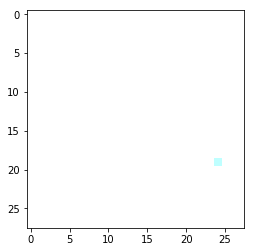

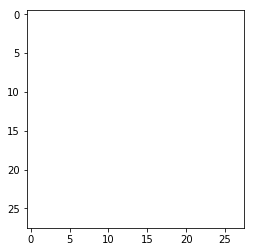

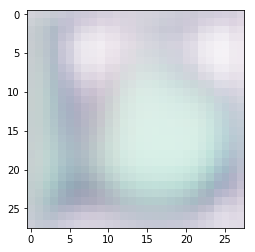

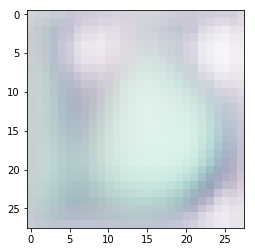

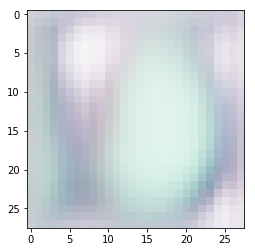

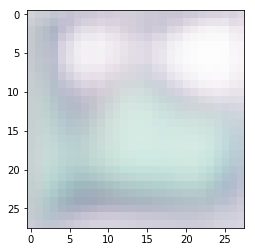

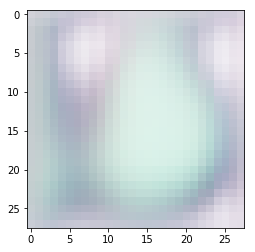

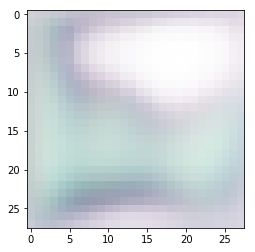

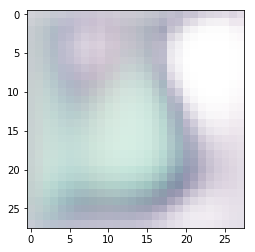

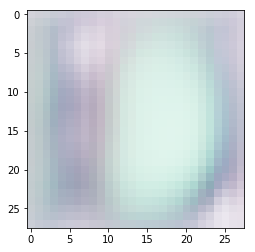

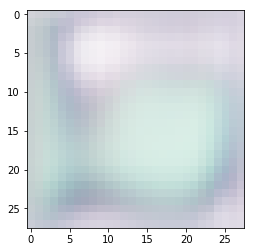

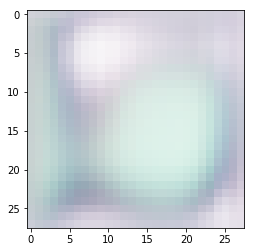

Epoch [1/50], Step [1/25], d_loss: 0.9866, g_loss: 0.8321, D(x): 0.63, D(G(z)): 0.38
Epoch [1/50], Step [2/25], d_loss: 1.0040, g_loss: 0.8421, D(x): 0.62, D(G(z)): 0.37
Epoch [1/50], Step [3/25], d_loss: 0.9762, g_loss: 0.8504, D(x): 0.63, D(G(z)): 0.37
Epoch [1/50], Step [4/25], d_loss: 0.9555, g_loss: 0.8499, D(x): 0.64, D(G(z)): 0.36
Epoch [1/50], Step [5/25], d_loss: 0.9560, g_loss: 0.8390, D(x): 0.65, D(G(z)): 0.37
Epoch [1/50], Step [6/25], d_loss: 0.9095, g_loss: 0.8236, D(x): 0.68, D(G(z)): 0.37
Epoch [1/50], Step [7/25], d_loss: 0.9029, g_loss: 0.8029, D(x): 0.69, D(G(z)): 0.38
Epoch [1/50], Step [8/25], d_loss: 0.8753, g_loss: 0.7830, D(x): 0.72, D(G(z)): 0.38
Epoch [1/50], Step [9/25], d_loss: 0.8814, g_loss: 0.7721, D(x): 0.72, D(G(z)): 0.39
Epoch [1/50], Step [10/25], d_loss: 0.8637, g_loss: 0.7690, D(x): 0.74, D(G(z)): 0.39
Epoch [1/50], Step [11/25], d_loss: 0.8610, g_loss: 0.7719, D(x): 0.74, D(G(z)): 0.40
Epoch [1/50], Step [12/25], d_loss: 0.8482, g_loss: 0.7789, D(x

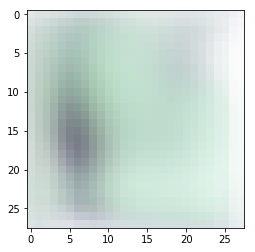

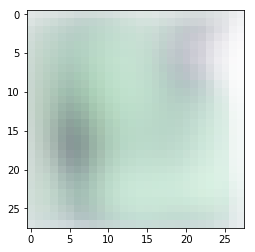

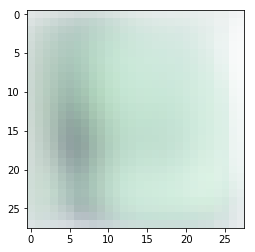

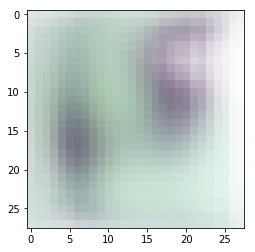

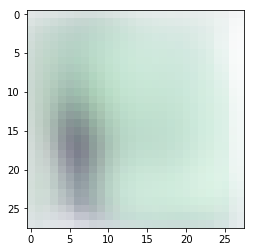

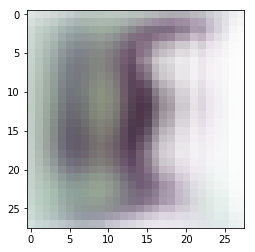

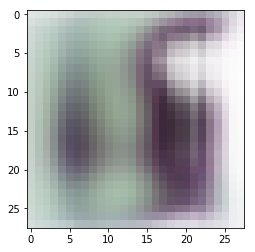

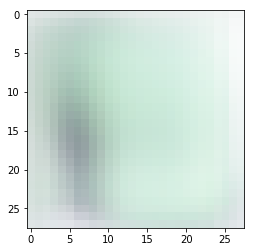

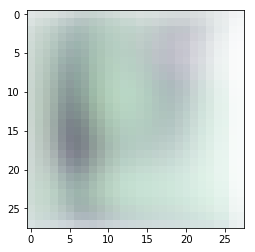

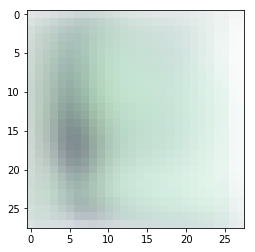

Epoch [2/50], Step [1/25], d_loss: 1.1899, g_loss: 0.4938, D(x): 0.78, D(G(z)): 0.57
Epoch [2/50], Step [2/25], d_loss: 1.4073, g_loss: 0.3774, D(x): 0.74, D(G(z)): 0.63
Epoch [2/50], Step [3/25], d_loss: 1.5098, g_loss: 0.3525, D(x): 0.73, D(G(z)): 0.65
Epoch [2/50], Step [4/25], d_loss: 1.5270, g_loss: 0.3758, D(x): 0.70, D(G(z)): 0.64
Epoch [2/50], Step [5/25], d_loss: 1.5248, g_loss: 0.4214, D(x): 0.67, D(G(z)): 0.63
Epoch [2/50], Step [6/25], d_loss: 1.4523, g_loss: 0.4822, D(x): 0.66, D(G(z)): 0.60
Epoch [2/50], Step [7/25], d_loss: 1.4251, g_loss: 0.5547, D(x): 0.62, D(G(z)): 0.57
Epoch [2/50], Step [8/25], d_loss: 1.3633, g_loss: 0.6241, D(x): 0.61, D(G(z)): 0.53
Epoch [2/50], Step [9/25], d_loss: 1.3663, g_loss: 0.6982, D(x): 0.57, D(G(z)): 0.50
Epoch [2/50], Step [10/25], d_loss: 1.3209, g_loss: 0.7537, D(x): 0.56, D(G(z)): 0.48
Epoch [2/50], Step [11/25], d_loss: 1.3256, g_loss: 0.8056, D(x): 0.54, D(G(z)): 0.45
Epoch [2/50], Step [12/25], d_loss: 1.3451, g_loss: 0.8311, D(x

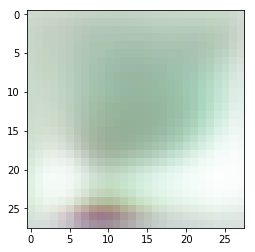

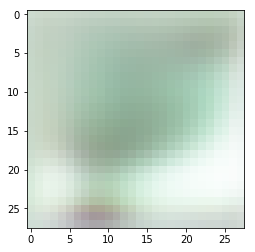

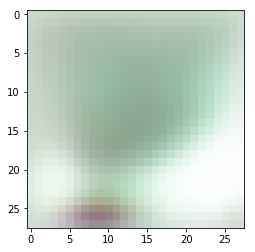

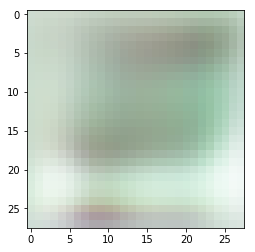

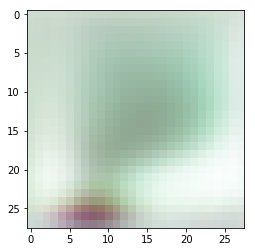

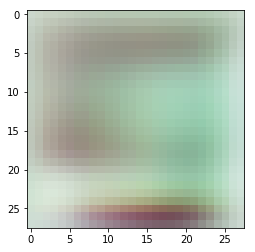

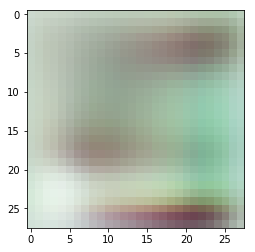

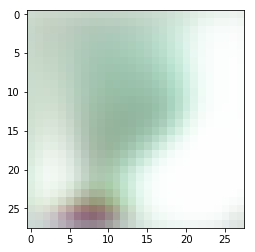

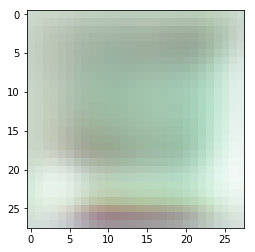

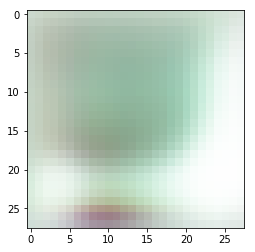

Epoch [3/50], Step [1/25], d_loss: 1.5835, g_loss: 0.6284, D(x): 0.51, D(G(z)): 0.53
Epoch [3/50], Step [2/25], d_loss: 1.5699, g_loss: 0.6689, D(x): 0.50, D(G(z)): 0.51
Epoch [3/50], Step [3/25], d_loss: 1.5577, g_loss: 0.7077, D(x): 0.50, D(G(z)): 0.50
Epoch [3/50], Step [4/25], d_loss: 1.5553, g_loss: 0.7406, D(x): 0.49, D(G(z)): 0.49
Epoch [3/50], Step [5/25], d_loss: 1.5456, g_loss: 0.7645, D(x): 0.49, D(G(z)): 0.48
Epoch [3/50], Step [6/25], d_loss: 1.5203, g_loss: 0.7702, D(x): 0.50, D(G(z)): 0.48
Epoch [3/50], Step [7/25], d_loss: 1.5240, g_loss: 0.7776, D(x): 0.50, D(G(z)): 0.48
Epoch [3/50], Step [8/25], d_loss: 1.5357, g_loss: 0.7713, D(x): 0.49, D(G(z)): 0.48
Epoch [3/50], Step [9/25], d_loss: 1.5304, g_loss: 0.7610, D(x): 0.50, D(G(z)): 0.48
Epoch [3/50], Step [10/25], d_loss: 1.5314, g_loss: 0.7429, D(x): 0.49, D(G(z)): 0.49
Epoch [3/50], Step [11/25], d_loss: 1.5312, g_loss: 0.7365, D(x): 0.49, D(G(z)): 0.49
Epoch [3/50], Step [12/25], d_loss: 1.5443, g_loss: 0.7285, D(x

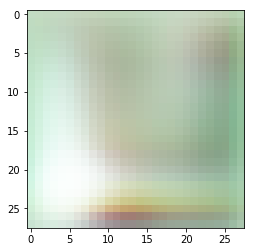

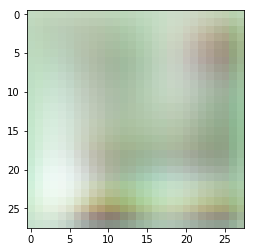

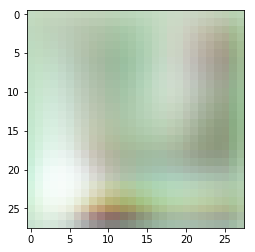

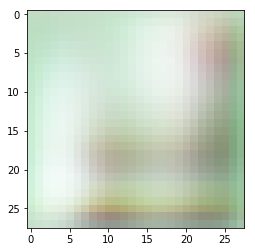

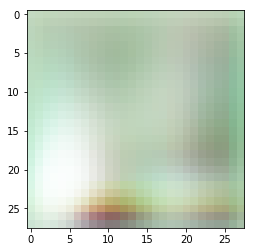

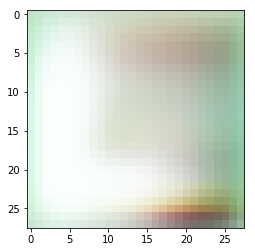

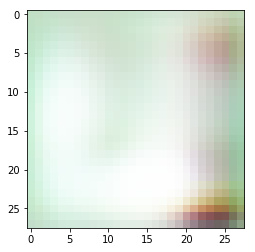

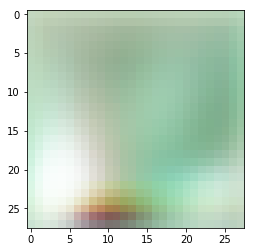

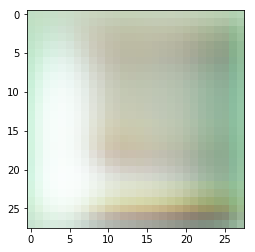

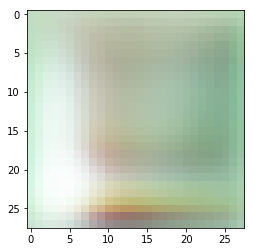

Epoch [4/50], Step [1/25], d_loss: 0.9753, g_loss: 1.0772, D(x): 0.58, D(G(z)): 0.31
Epoch [4/50], Step [2/25], d_loss: 0.9509, g_loss: 1.0816, D(x): 0.59, D(G(z)): 0.31
Epoch [4/50], Step [3/25], d_loss: 0.9426, g_loss: 1.0838, D(x): 0.59, D(G(z)): 0.31
Epoch [4/50], Step [4/25], d_loss: 0.9245, g_loss: 1.0741, D(x): 0.60, D(G(z)): 0.31
Epoch [4/50], Step [5/25], d_loss: 0.8991, g_loss: 1.0680, D(x): 0.62, D(G(z)): 0.31
Epoch [4/50], Step [6/25], d_loss: 0.8782, g_loss: 1.0627, D(x): 0.64, D(G(z)): 0.32
Epoch [4/50], Step [7/25], d_loss: 0.8725, g_loss: 1.0485, D(x): 0.64, D(G(z)): 0.32
Epoch [4/50], Step [8/25], d_loss: 0.8696, g_loss: 1.0285, D(x): 0.65, D(G(z)): 0.33
Epoch [4/50], Step [9/25], d_loss: 0.8492, g_loss: 1.0175, D(x): 0.67, D(G(z)): 0.33
Epoch [4/50], Step [10/25], d_loss: 0.8449, g_loss: 0.9978, D(x): 0.68, D(G(z)): 0.34
Epoch [4/50], Step [11/25], d_loss: 0.8593, g_loss: 0.9725, D(x): 0.68, D(G(z)): 0.35
Epoch [4/50], Step [12/25], d_loss: 0.8803, g_loss: 0.9546, D(x

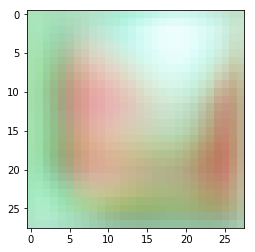

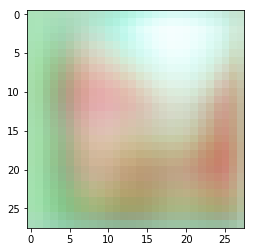

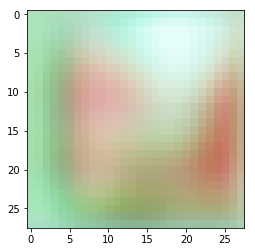

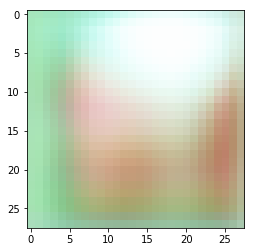

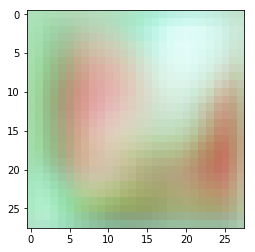

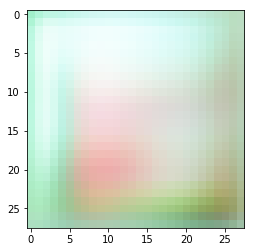

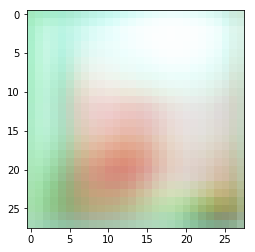

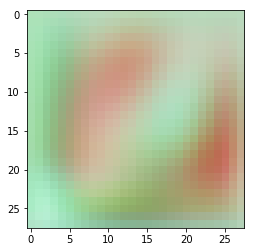

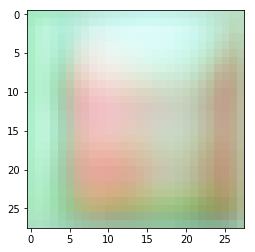

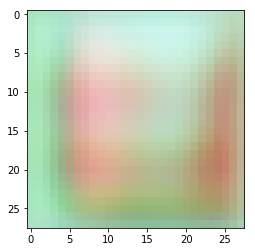

Epoch [5/50], Step [1/25], d_loss: 1.2036, g_loss: 0.6631, D(x): 0.65, D(G(z)): 0.50
Epoch [5/50], Step [2/25], d_loss: 1.2354, g_loss: 0.6649, D(x): 0.63, D(G(z)): 0.50
Epoch [5/50], Step [3/25], d_loss: 1.2897, g_loss: 0.6639, D(x): 0.61, D(G(z)): 0.50
Epoch [5/50], Step [4/25], d_loss: 1.3271, g_loss: 0.6599, D(x): 0.59, D(G(z)): 0.50
Epoch [5/50], Step [5/25], d_loss: 1.3474, g_loss: 0.6589, D(x): 0.58, D(G(z)): 0.51
Epoch [5/50], Step [6/25], d_loss: 1.3584, g_loss: 0.6543, D(x): 0.58, D(G(z)): 0.51
Epoch [5/50], Step [7/25], d_loss: 1.3949, g_loss: 0.6576, D(x): 0.56, D(G(z)): 0.51
Epoch [5/50], Step [8/25], d_loss: 1.4067, g_loss: 0.6581, D(x): 0.55, D(G(z)): 0.51
Epoch [5/50], Step [9/25], d_loss: 1.4521, g_loss: 0.6577, D(x): 0.54, D(G(z)): 0.51
Epoch [5/50], Step [10/25], d_loss: 1.4757, g_loss: 0.6481, D(x): 0.53, D(G(z)): 0.51
Epoch [5/50], Step [11/25], d_loss: 1.5297, g_loss: 0.6264, D(x): 0.52, D(G(z)): 0.52
Epoch [5/50], Step [12/25], d_loss: 1.6063, g_loss: 0.5878, D(x

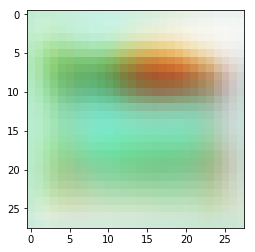

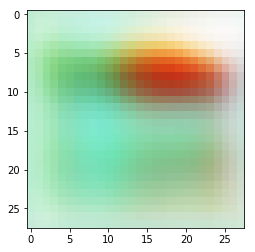

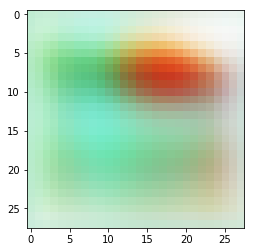

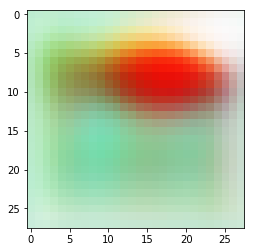

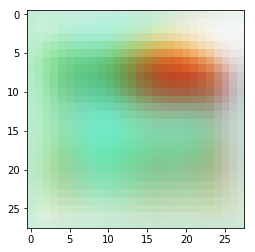

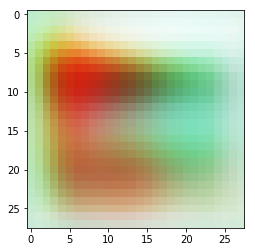

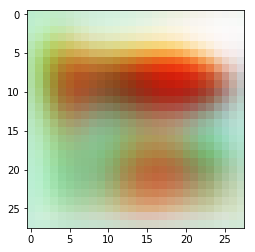

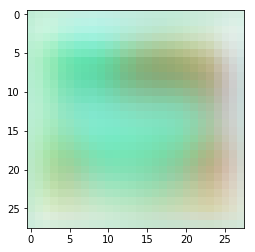

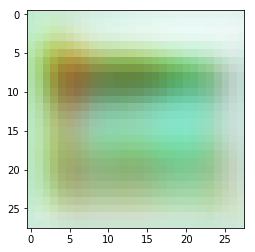

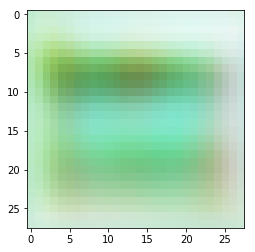

Epoch [6/50], Step [1/25], d_loss: 1.4380, g_loss: 0.6662, D(x): 0.51, D(G(z)): 0.48
Epoch [6/50], Step [2/25], d_loss: 1.4136, g_loss: 0.6970, D(x): 0.51, D(G(z)): 0.46
Epoch [6/50], Step [3/25], d_loss: 1.3929, g_loss: 0.7261, D(x): 0.50, D(G(z)): 0.45
Epoch [6/50], Step [4/25], d_loss: 1.3694, g_loss: 0.7586, D(x): 0.50, D(G(z)): 0.44
Epoch [6/50], Step [5/25], d_loss: 1.3462, g_loss: 0.7829, D(x): 0.50, D(G(z)): 0.42
Epoch [6/50], Step [6/25], d_loss: 1.2766, g_loss: 0.8067, D(x): 0.52, D(G(z)): 0.41
Epoch [6/50], Step [7/25], d_loss: 1.2528, g_loss: 0.8335, D(x): 0.53, D(G(z)): 0.40
Epoch [6/50], Step [8/25], d_loss: 1.2295, g_loss: 0.8513, D(x): 0.53, D(G(z)): 0.40
Epoch [6/50], Step [9/25], d_loss: 1.1807, g_loss: 0.8745, D(x): 0.54, D(G(z)): 0.39
Epoch [6/50], Step [10/25], d_loss: 1.1624, g_loss: 0.8949, D(x): 0.55, D(G(z)): 0.38
Epoch [6/50], Step [11/25], d_loss: 1.1388, g_loss: 0.9173, D(x): 0.55, D(G(z)): 0.37
Epoch [6/50], Step [12/25], d_loss: 1.1150, g_loss: 0.9330, D(x

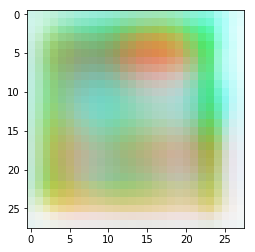

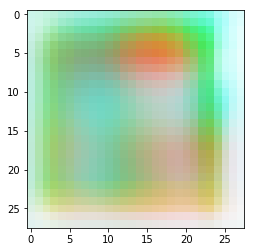

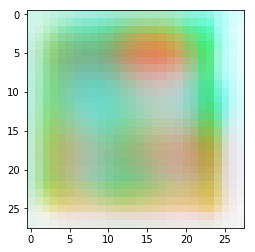

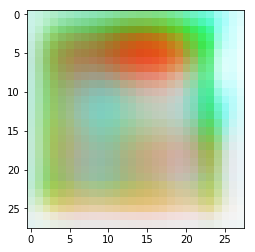

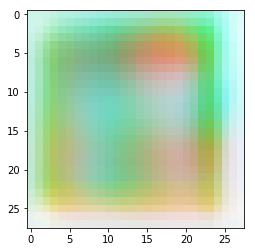

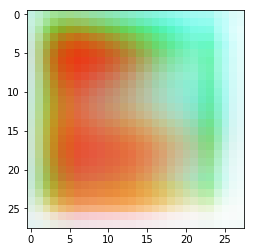

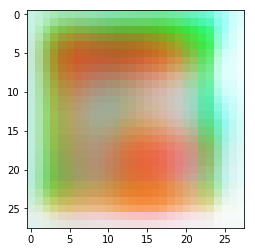

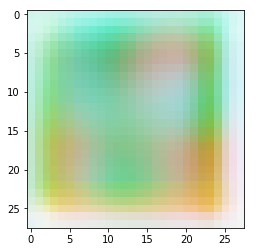

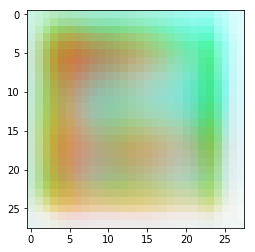

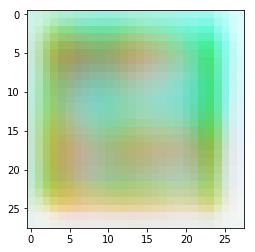

Epoch [7/50], Step [1/25], d_loss: 1.2628, g_loss: 0.6185, D(x): 0.63, D(G(z)): 0.50
Epoch [7/50], Step [2/25], d_loss: 1.3185, g_loss: 0.5665, D(x): 0.63, D(G(z)): 0.53
Epoch [7/50], Step [3/25], d_loss: 1.4002, g_loss: 0.5284, D(x): 0.62, D(G(z)): 0.56
Epoch [7/50], Step [4/25], d_loss: 1.4506, g_loss: 0.5011, D(x): 0.62, D(G(z)): 0.58
Epoch [7/50], Step [5/25], d_loss: 1.5121, g_loss: 0.4881, D(x): 0.61, D(G(z)): 0.59
Epoch [7/50], Step [6/25], d_loss: 1.5216, g_loss: 0.4907, D(x): 0.61, D(G(z)): 0.59
Epoch [7/50], Step [7/25], d_loss: 1.5385, g_loss: 0.5062, D(x): 0.60, D(G(z)): 0.59
Epoch [7/50], Step [8/25], d_loss: 1.5501, g_loss: 0.5380, D(x): 0.58, D(G(z)): 0.58
Epoch [7/50], Step [9/25], d_loss: 1.4991, g_loss: 0.5799, D(x): 0.58, D(G(z)): 0.57
Epoch [7/50], Step [10/25], d_loss: 1.4817, g_loss: 0.6362, D(x): 0.56, D(G(z)): 0.54
Epoch [7/50], Step [11/25], d_loss: 1.4517, g_loss: 0.6943, D(x): 0.55, D(G(z)): 0.52
Epoch [7/50], Step [12/25], d_loss: 1.4150, g_loss: 0.7595, D(x

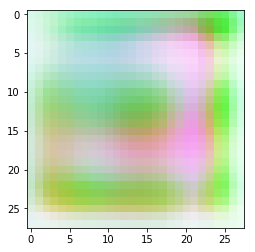

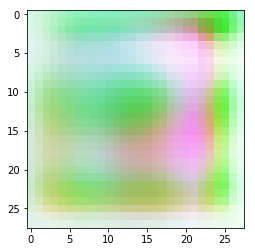

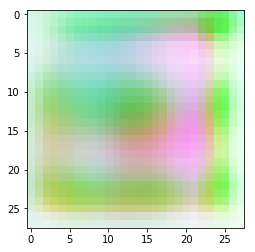

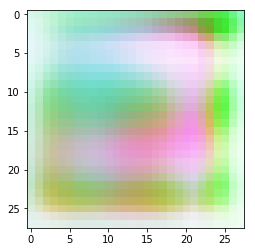

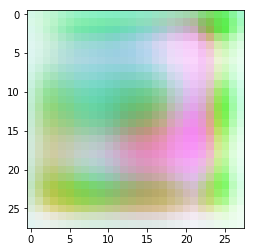

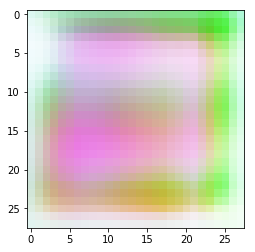

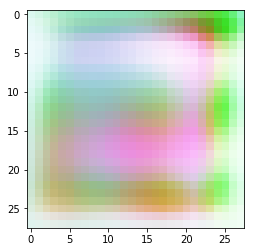

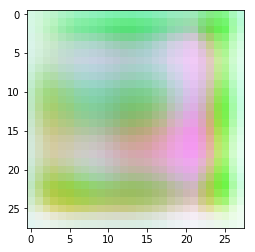

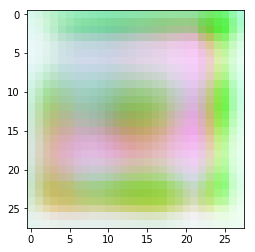

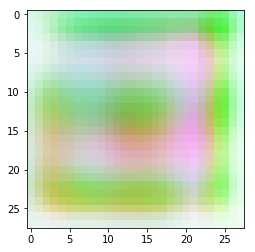

Epoch [8/50], Step [1/25], d_loss: 1.1693, g_loss: 0.9244, D(x): 0.55, D(G(z)): 0.40
Epoch [8/50], Step [2/25], d_loss: 1.1673, g_loss: 0.8867, D(x): 0.57, D(G(z)): 0.41
Epoch [8/50], Step [3/25], d_loss: 1.1684, g_loss: 0.8437, D(x): 0.58, D(G(z)): 0.42
Epoch [8/50], Step [4/25], d_loss: 1.1566, g_loss: 0.8029, D(x): 0.59, D(G(z)): 0.43
Epoch [8/50], Step [5/25], d_loss: 1.1683, g_loss: 0.7677, D(x): 0.60, D(G(z)): 0.45
Epoch [8/50], Step [6/25], d_loss: 1.1718, g_loss: 0.7364, D(x): 0.61, D(G(z)): 0.46
Epoch [8/50], Step [7/25], d_loss: 1.1713, g_loss: 0.7112, D(x): 0.62, D(G(z)): 0.47
Epoch [8/50], Step [8/25], d_loss: 1.2046, g_loss: 0.6912, D(x): 0.61, D(G(z)): 0.48
Epoch [8/50], Step [9/25], d_loss: 1.1851, g_loss: 0.6761, D(x): 0.63, D(G(z)): 0.48
Epoch [8/50], Step [10/25], d_loss: 1.2042, g_loss: 0.6690, D(x): 0.62, D(G(z)): 0.49
Epoch [8/50], Step [11/25], d_loss: 1.2076, g_loss: 0.6593, D(x): 0.62, D(G(z)): 0.49
Epoch [8/50], Step [12/25], d_loss: 1.2079, g_loss: 0.6518, D(x

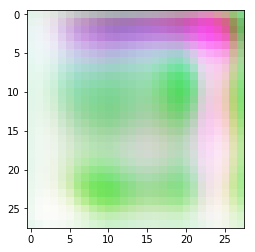

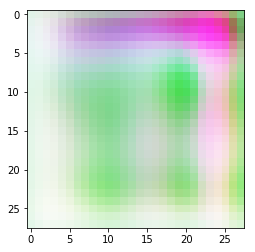

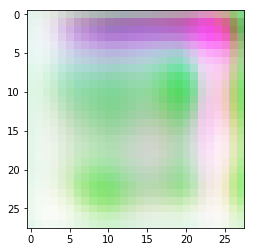

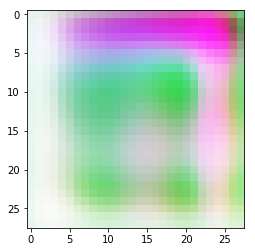

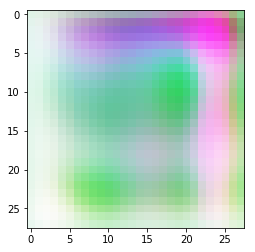

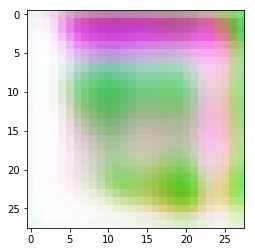

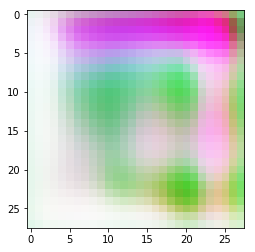

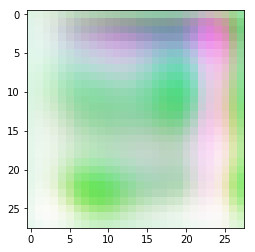

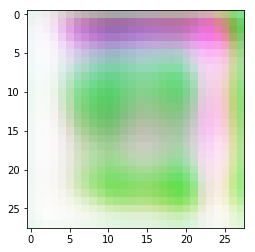

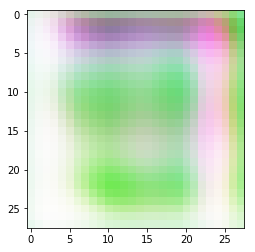

Epoch [9/50], Step [1/25], d_loss: 1.1227, g_loss: 0.7317, D(x): 0.63, D(G(z)): 0.46
Epoch [9/50], Step [2/25], d_loss: 1.1333, g_loss: 0.7399, D(x): 0.62, D(G(z)): 0.46
Epoch [9/50], Step [3/25], d_loss: 1.1285, g_loss: 0.7428, D(x): 0.62, D(G(z)): 0.45
Epoch [9/50], Step [4/25], d_loss: 1.1274, g_loss: 0.7431, D(x): 0.62, D(G(z)): 0.45
Epoch [9/50], Step [5/25], d_loss: 1.1477, g_loss: 0.7416, D(x): 0.62, D(G(z)): 0.45
Epoch [9/50], Step [6/25], d_loss: 1.1465, g_loss: 0.7314, D(x): 0.62, D(G(z)): 0.46
Epoch [9/50], Step [7/25], d_loss: 1.1591, g_loss: 0.7150, D(x): 0.62, D(G(z)): 0.46
Epoch [9/50], Step [8/25], d_loss: 1.1934, g_loss: 0.7051, D(x): 0.60, D(G(z)): 0.47
Epoch [9/50], Step [9/25], d_loss: 1.1843, g_loss: 0.6939, D(x): 0.61, D(G(z)): 0.47
Epoch [9/50], Step [10/25], d_loss: 1.2100, g_loss: 0.6876, D(x): 0.61, D(G(z)): 0.48
Epoch [9/50], Step [11/25], d_loss: 1.2155, g_loss: 0.6865, D(x): 0.60, D(G(z)): 0.48
Epoch [9/50], Step [12/25], d_loss: 1.2178, g_loss: 0.6897, D(x

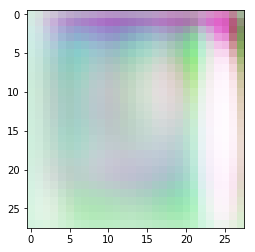

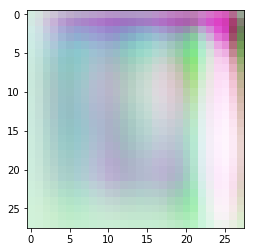

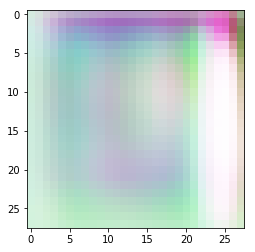

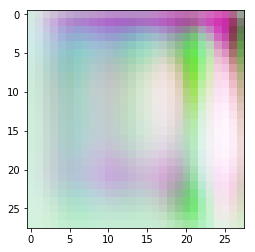

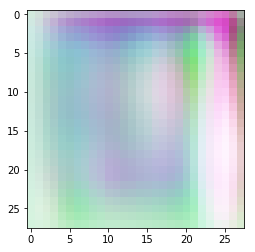

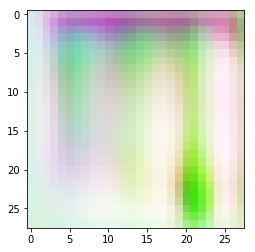

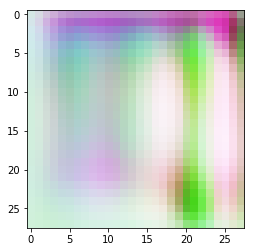

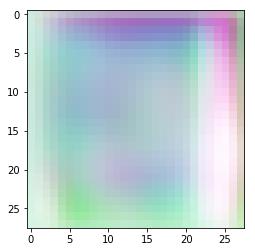

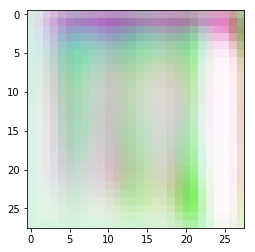

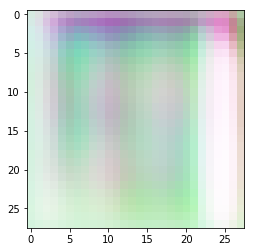

Epoch [10/50], Step [1/25], d_loss: 1.1651, g_loss: 0.8323, D(x): 0.57, D(G(z)): 0.41
Epoch [10/50], Step [2/25], d_loss: 1.1540, g_loss: 0.8407, D(x): 0.57, D(G(z)): 0.41
Epoch [10/50], Step [3/25], d_loss: 1.1537, g_loss: 0.8490, D(x): 0.56, D(G(z)): 0.40
Epoch [10/50], Step [4/25], d_loss: 1.1417, g_loss: 0.8588, D(x): 0.56, D(G(z)): 0.40
Epoch [10/50], Step [5/25], d_loss: 1.1334, g_loss: 0.8686, D(x): 0.56, D(G(z)): 0.39
Epoch [10/50], Step [6/25], d_loss: 1.0957, g_loss: 0.8796, D(x): 0.58, D(G(z)): 0.39
Epoch [10/50], Step [7/25], d_loss: 1.0812, g_loss: 0.8910, D(x): 0.58, D(G(z)): 0.38
Epoch [10/50], Step [8/25], d_loss: 1.0839, g_loss: 0.8993, D(x): 0.57, D(G(z)): 0.38
Epoch [10/50], Step [9/25], d_loss: 1.0290, g_loss: 0.9135, D(x): 0.60, D(G(z)): 0.37
Epoch [10/50], Step [10/25], d_loss: 1.0288, g_loss: 0.9219, D(x): 0.59, D(G(z)): 0.37
Epoch [10/50], Step [11/25], d_loss: 1.0009, g_loss: 0.9310, D(x): 0.60, D(G(z)): 0.36
Epoch [10/50], Step [12/25], d_loss: 0.9924, g_loss:

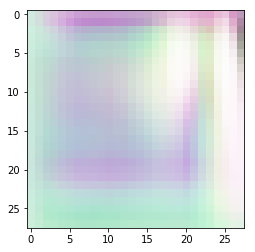

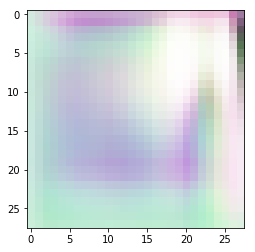

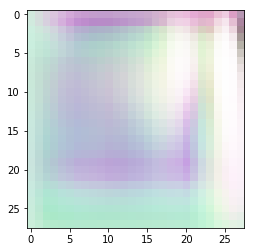

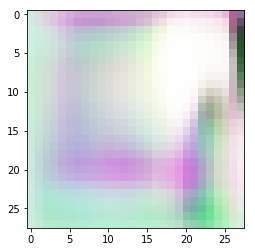

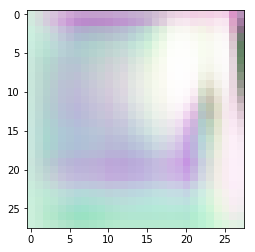

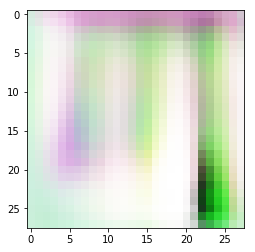

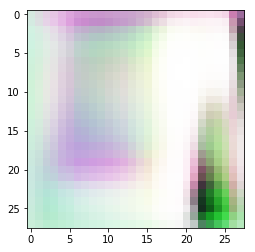

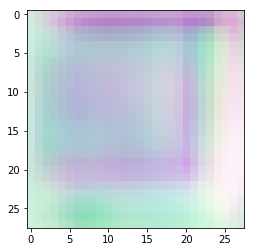

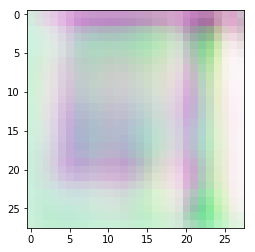

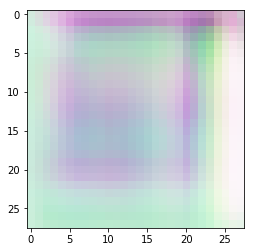

Epoch [11/50], Step [1/25], d_loss: 0.9125, g_loss: 0.7753, D(x): 0.69, D(G(z)): 0.40
Epoch [11/50], Step [2/25], d_loss: 0.9291, g_loss: 0.7607, D(x): 0.69, D(G(z)): 0.41
Epoch [11/50], Step [3/25], d_loss: 0.9492, g_loss: 0.7488, D(x): 0.68, D(G(z)): 0.41
Epoch [11/50], Step [4/25], d_loss: 0.9611, g_loss: 0.7430, D(x): 0.68, D(G(z)): 0.42
Epoch [11/50], Step [5/25], d_loss: 0.9646, g_loss: 0.7344, D(x): 0.68, D(G(z)): 0.42
Epoch [11/50], Step [6/25], d_loss: 0.9577, g_loss: 0.7357, D(x): 0.68, D(G(z)): 0.42
Epoch [11/50], Step [7/25], d_loss: 0.9679, g_loss: 0.7376, D(x): 0.68, D(G(z)): 0.42
Epoch [11/50], Step [8/25], d_loss: 0.9876, g_loss: 0.7399, D(x): 0.67, D(G(z)): 0.42
Epoch [11/50], Step [9/25], d_loss: 0.9788, g_loss: 0.7392, D(x): 0.67, D(G(z)): 0.42
Epoch [11/50], Step [10/25], d_loss: 1.0003, g_loss: 0.7461, D(x): 0.66, D(G(z)): 0.42
Epoch [11/50], Step [11/25], d_loss: 1.0101, g_loss: 0.7440, D(x): 0.66, D(G(z)): 0.42
Epoch [11/50], Step [12/25], d_loss: 1.0292, g_loss:

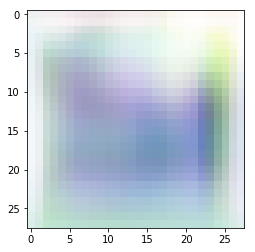

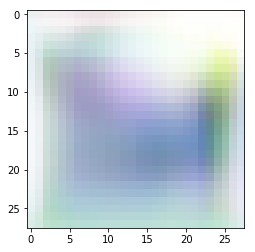

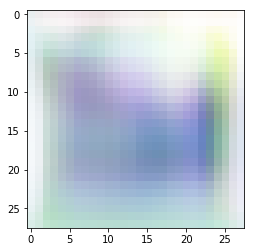

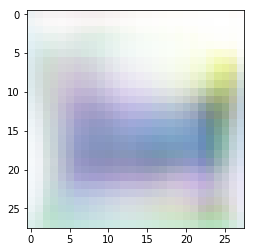

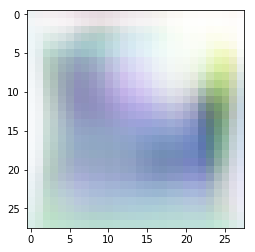

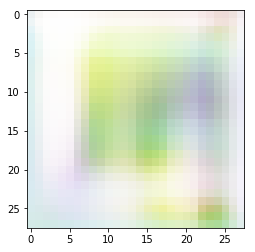

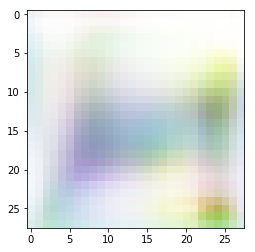

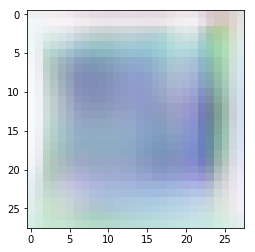

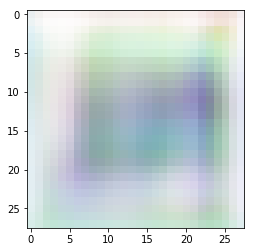

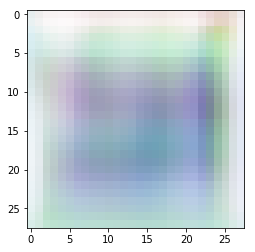

Epoch [12/50], Step [1/25], d_loss: 1.3568, g_loss: 0.6049, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [2/25], d_loss: 1.3512, g_loss: 0.5939, D(x): 0.57, D(G(z)): 0.51
Epoch [12/50], Step [3/25], d_loss: 1.3975, g_loss: 0.5938, D(x): 0.55, D(G(z)): 0.51
Epoch [12/50], Step [4/25], d_loss: 1.3778, g_loss: 0.5946, D(x): 0.56, D(G(z)): 0.51
Epoch [12/50], Step [5/25], d_loss: 1.3692, g_loss: 0.5981, D(x): 0.56, D(G(z)): 0.51
Epoch [12/50], Step [6/25], d_loss: 1.3684, g_loss: 0.6003, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [7/25], d_loss: 1.3759, g_loss: 0.6025, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [8/25], d_loss: 1.4020, g_loss: 0.6075, D(x): 0.54, D(G(z)): 0.50
Epoch [12/50], Step [9/25], d_loss: 1.3498, g_loss: 0.6029, D(x): 0.57, D(G(z)): 0.50
Epoch [12/50], Step [10/25], d_loss: 1.3842, g_loss: 0.6072, D(x): 0.55, D(G(z)): 0.50
Epoch [12/50], Step [11/25], d_loss: 1.3764, g_loss: 0.6111, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [12/25], d_loss: 1.4060, g_loss:

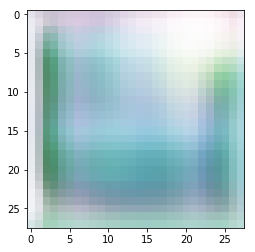

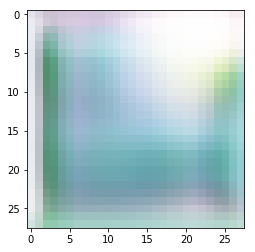

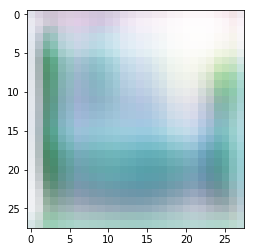

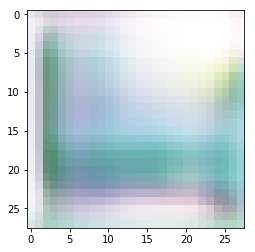

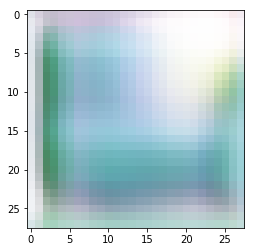

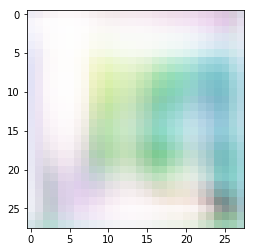

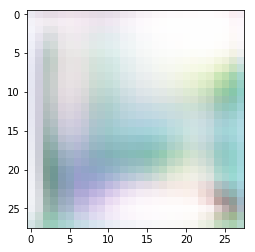

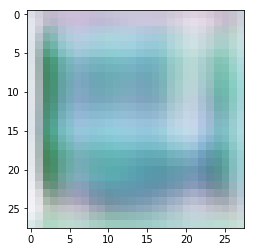

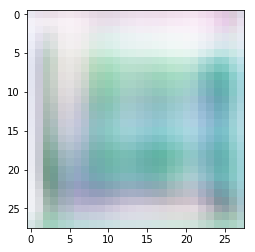

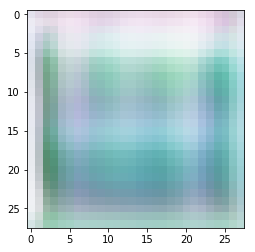

Epoch [13/50], Step [1/25], d_loss: 1.6840, g_loss: 0.5149, D(x): 0.46, D(G(z)): 0.55
Epoch [13/50], Step [2/25], d_loss: 1.6540, g_loss: 0.5017, D(x): 0.48, D(G(z)): 0.56
Epoch [13/50], Step [3/25], d_loss: 1.6973, g_loss: 0.4954, D(x): 0.46, D(G(z)): 0.56
Epoch [13/50], Step [4/25], d_loss: 1.6712, g_loss: 0.4964, D(x): 0.47, D(G(z)): 0.56
Epoch [13/50], Step [5/25], d_loss: 1.6612, g_loss: 0.4951, D(x): 0.48, D(G(z)): 0.56
Epoch [13/50], Step [6/25], d_loss: 1.6575, g_loss: 0.5019, D(x): 0.48, D(G(z)): 0.56
Epoch [13/50], Step [7/25], d_loss: 1.6357, g_loss: 0.5114, D(x): 0.48, D(G(z)): 0.55
Epoch [13/50], Step [8/25], d_loss: 1.6475, g_loss: 0.5270, D(x): 0.47, D(G(z)): 0.55
Epoch [13/50], Step [9/25], d_loss: 1.5624, g_loss: 0.5477, D(x): 0.49, D(G(z)): 0.54
Epoch [13/50], Step [10/25], d_loss: 1.5695, g_loss: 0.5721, D(x): 0.48, D(G(z)): 0.52
Epoch [13/50], Step [11/25], d_loss: 1.5326, g_loss: 0.6043, D(x): 0.48, D(G(z)): 0.51
Epoch [13/50], Step [12/25], d_loss: 1.4882, g_loss:

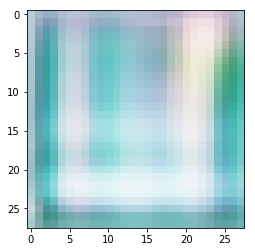

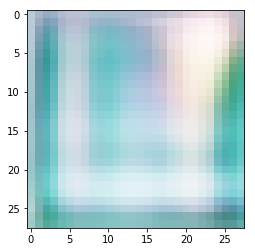

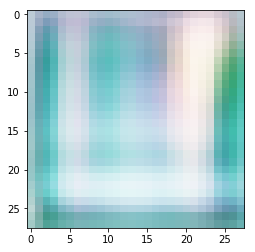

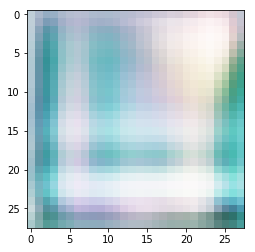

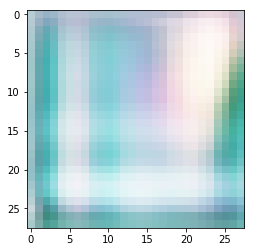

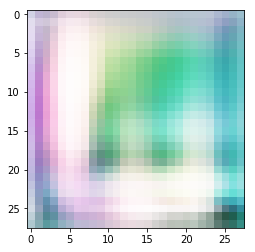

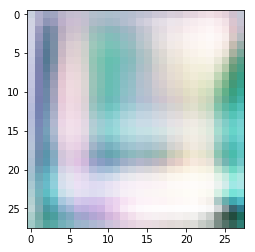

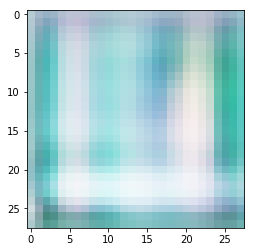

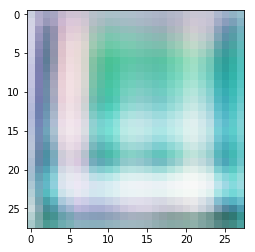

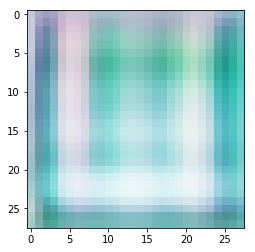

Epoch [14/50], Step [1/25], d_loss: 0.8208, g_loss: 1.0590, D(x): 0.67, D(G(z)): 0.32
Epoch [14/50], Step [2/25], d_loss: 0.8007, g_loss: 1.0676, D(x): 0.68, D(G(z)): 0.31
Epoch [14/50], Step [3/25], d_loss: 0.7974, g_loss: 1.0610, D(x): 0.69, D(G(z)): 0.32
Epoch [14/50], Step [4/25], d_loss: 0.7895, g_loss: 1.0554, D(x): 0.69, D(G(z)): 0.32
Epoch [14/50], Step [5/25], d_loss: 0.7918, g_loss: 1.0393, D(x): 0.70, D(G(z)): 0.32
Epoch [14/50], Step [6/25], d_loss: 0.7796, g_loss: 1.0067, D(x): 0.71, D(G(z)): 0.33
Epoch [14/50], Step [7/25], d_loss: 0.7810, g_loss: 0.9663, D(x): 0.73, D(G(z)): 0.34
Epoch [14/50], Step [8/25], d_loss: 0.8169, g_loss: 0.9083, D(x): 0.72, D(G(z)): 0.36
Epoch [14/50], Step [9/25], d_loss: 0.8474, g_loss: 0.8456, D(x): 0.73, D(G(z)): 0.39
Epoch [14/50], Step [10/25], d_loss: 0.8945, g_loss: 0.7737, D(x): 0.73, D(G(z)): 0.42
Epoch [14/50], Step [11/25], d_loss: 0.9514, g_loss: 0.6983, D(x): 0.73, D(G(z)): 0.44
Epoch [14/50], Step [12/25], d_loss: 0.9960, g_loss:

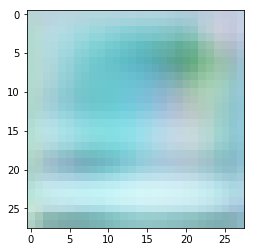

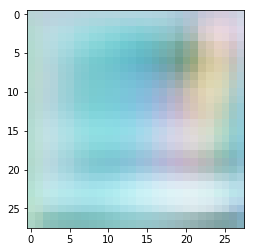

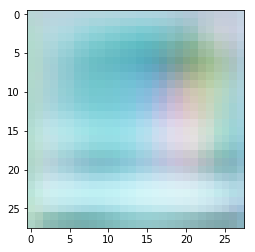

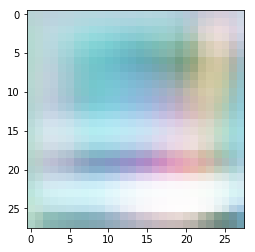

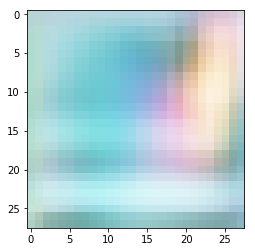

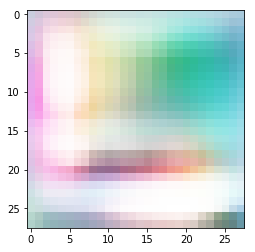

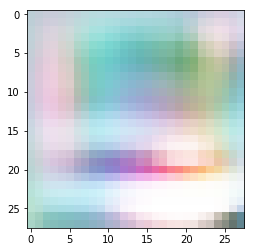

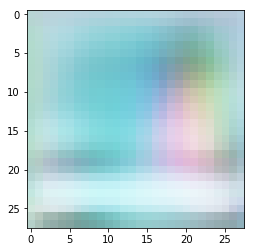

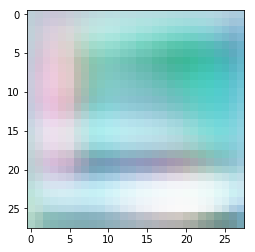

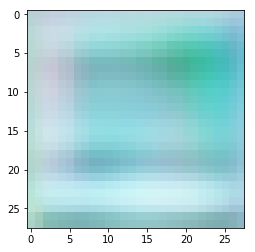

Epoch [15/50], Step [1/25], d_loss: 0.9917, g_loss: 0.7803, D(x): 0.69, D(G(z)): 0.42
Epoch [15/50], Step [2/25], d_loss: 1.0345, g_loss: 0.7998, D(x): 0.65, D(G(z)): 0.41
Epoch [15/50], Step [3/25], d_loss: 1.0485, g_loss: 0.8103, D(x): 0.64, D(G(z)): 0.41
Epoch [15/50], Step [4/25], d_loss: 1.0799, g_loss: 0.8182, D(x): 0.62, D(G(z)): 0.40
Epoch [15/50], Step [5/25], d_loss: 1.1118, g_loss: 0.8225, D(x): 0.60, D(G(z)): 0.40
Epoch [15/50], Step [6/25], d_loss: 1.1051, g_loss: 0.8188, D(x): 0.61, D(G(z)): 0.40
Epoch [15/50], Step [7/25], d_loss: 1.1285, g_loss: 0.8056, D(x): 0.60, D(G(z)): 0.41
Epoch [15/50], Step [8/25], d_loss: 1.1624, g_loss: 0.7874, D(x): 0.59, D(G(z)): 0.42
Epoch [15/50], Step [9/25], d_loss: 1.2054, g_loss: 0.7658, D(x): 0.58, D(G(z)): 0.43
Epoch [15/50], Step [10/25], d_loss: 1.2216, g_loss: 0.7428, D(x): 0.58, D(G(z)): 0.44
Epoch [15/50], Step [11/25], d_loss: 1.2660, g_loss: 0.7208, D(x): 0.57, D(G(z)): 0.45
Epoch [15/50], Step [12/25], d_loss: 1.2785, g_loss:

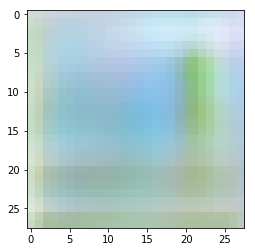

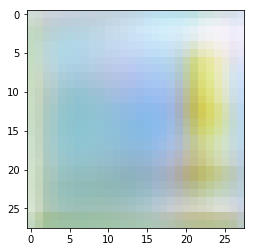

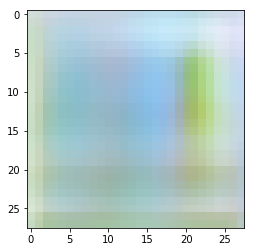

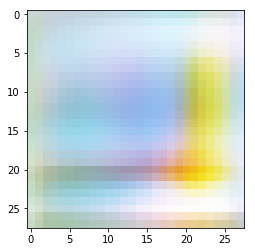

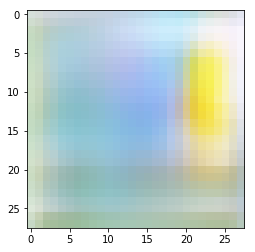

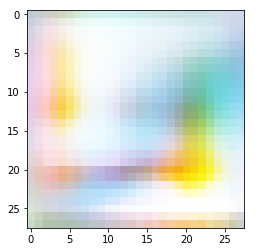

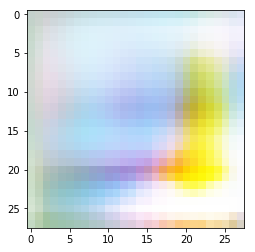

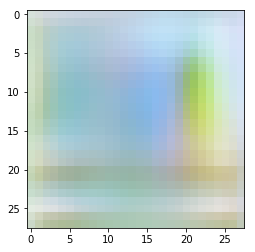

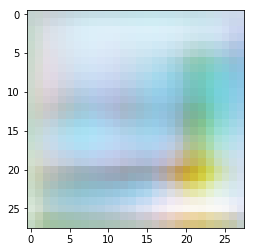

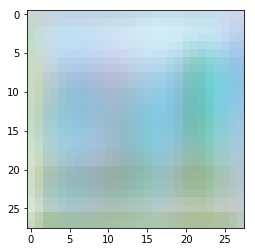

Epoch [16/50], Step [1/25], d_loss: 1.3047, g_loss: 0.7365, D(x): 0.56, D(G(z)): 0.46
Epoch [16/50], Step [2/25], d_loss: 1.3615, g_loss: 0.7349, D(x): 0.53, D(G(z)): 0.46
Epoch [16/50], Step [3/25], d_loss: 1.3856, g_loss: 0.7357, D(x): 0.52, D(G(z)): 0.46
Epoch [16/50], Step [4/25], d_loss: 1.4168, g_loss: 0.7349, D(x): 0.50, D(G(z)): 0.46
Epoch [16/50], Step [5/25], d_loss: 1.4402, g_loss: 0.7368, D(x): 0.49, D(G(z)): 0.46
Epoch [16/50], Step [6/25], d_loss: 1.4299, g_loss: 0.7303, D(x): 0.50, D(G(z)): 0.46
Epoch [16/50], Step [7/25], d_loss: 1.4362, g_loss: 0.7384, D(x): 0.49, D(G(z)): 0.46
Epoch [16/50], Step [8/25], d_loss: 1.4638, g_loss: 0.7366, D(x): 0.48, D(G(z)): 0.46
Epoch [16/50], Step [9/25], d_loss: 1.4711, g_loss: 0.7382, D(x): 0.47, D(G(z)): 0.46
Epoch [16/50], Step [10/25], d_loss: 1.4652, g_loss: 0.7387, D(x): 0.47, D(G(z)): 0.45
Epoch [16/50], Step [11/25], d_loss: 1.4813, g_loss: 0.7481, D(x): 0.46, D(G(z)): 0.45
Epoch [16/50], Step [12/25], d_loss: 1.4720, g_loss:

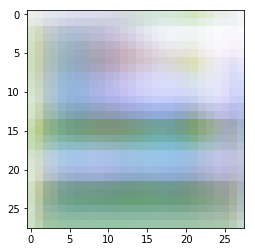

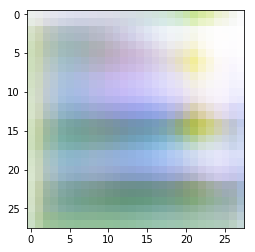

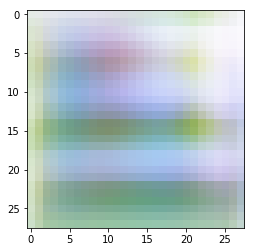

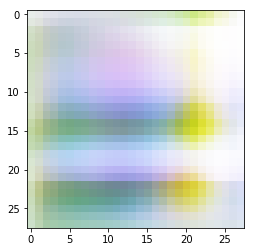

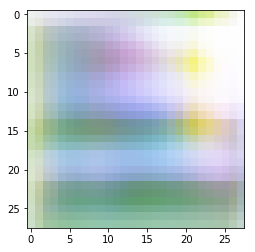

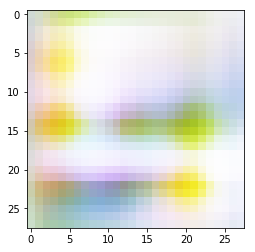

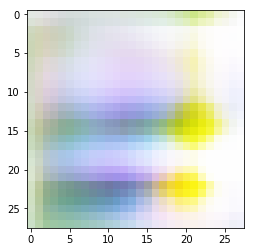

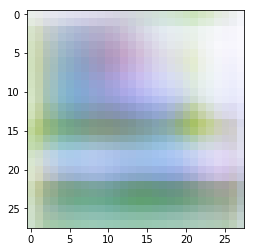

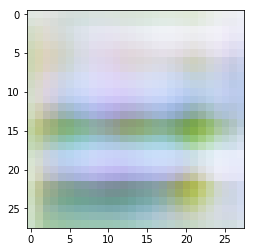

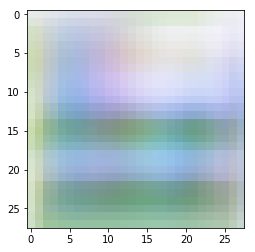

Epoch [17/50], Step [1/25], d_loss: 1.3964, g_loss: 0.6612, D(x): 0.52, D(G(z)): 0.47
Epoch [17/50], Step [2/25], d_loss: 1.4016, g_loss: 0.6616, D(x): 0.52, D(G(z)): 0.48
Epoch [17/50], Step [3/25], d_loss: 1.4076, g_loss: 0.6723, D(x): 0.51, D(G(z)): 0.47
Epoch [17/50], Step [4/25], d_loss: 1.4172, g_loss: 0.6943, D(x): 0.50, D(G(z)): 0.46
Epoch [17/50], Step [5/25], d_loss: 1.4047, g_loss: 0.7179, D(x): 0.50, D(G(z)): 0.46
Epoch [17/50], Step [6/25], d_loss: 1.3764, g_loss: 0.7441, D(x): 0.50, D(G(z)): 0.44
Epoch [17/50], Step [7/25], d_loss: 1.3592, g_loss: 0.7727, D(x): 0.50, D(G(z)): 0.43
Epoch [17/50], Step [8/25], d_loss: 1.3696, g_loss: 0.7953, D(x): 0.49, D(G(z)): 0.42
Epoch [17/50], Step [9/25], d_loss: 1.3225, g_loss: 0.8158, D(x): 0.51, D(G(z)): 0.42
Epoch [17/50], Step [10/25], d_loss: 1.3131, g_loss: 0.8218, D(x): 0.50, D(G(z)): 0.41
Epoch [17/50], Step [11/25], d_loss: 1.3138, g_loss: 0.8286, D(x): 0.50, D(G(z)): 0.41
Epoch [17/50], Step [12/25], d_loss: 1.3065, g_loss:

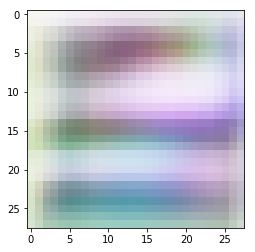

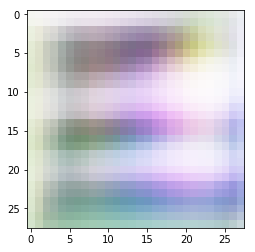

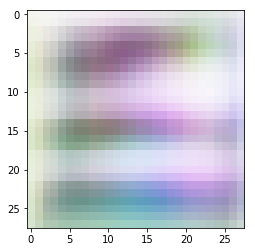

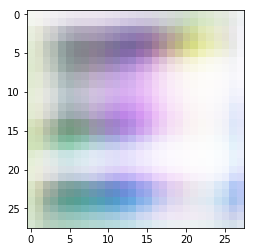

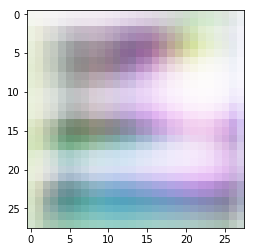

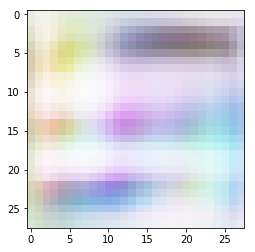

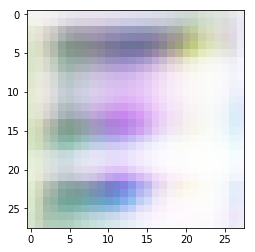

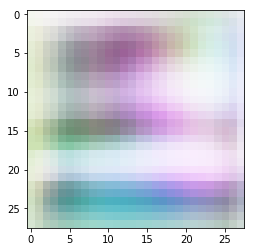

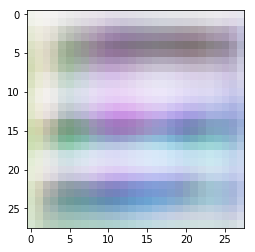

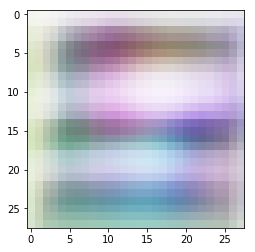

Epoch [18/50], Step [1/25], d_loss: 1.6522, g_loss: 0.4309, D(x): 0.52, D(G(z)): 0.58
Epoch [18/50], Step [2/25], d_loss: 1.6156, g_loss: 0.4415, D(x): 0.53, D(G(z)): 0.57
Epoch [18/50], Step [3/25], d_loss: 1.6380, g_loss: 0.4534, D(x): 0.52, D(G(z)): 0.57
Epoch [18/50], Step [4/25], d_loss: 1.6481, g_loss: 0.4688, D(x): 0.51, D(G(z)): 0.56
Epoch [18/50], Step [5/25], d_loss: 1.6507, g_loss: 0.4868, D(x): 0.50, D(G(z)): 0.55
Epoch [18/50], Step [6/25], d_loss: 1.6344, g_loss: 0.5094, D(x): 0.49, D(G(z)): 0.54
Epoch [18/50], Step [7/25], d_loss: 1.6262, g_loss: 0.5234, D(x): 0.48, D(G(z)): 0.53
Epoch [18/50], Step [8/25], d_loss: 1.6497, g_loss: 0.5423, D(x): 0.47, D(G(z)): 0.52
Epoch [18/50], Step [9/25], d_loss: 1.6044, g_loss: 0.5548, D(x): 0.48, D(G(z)): 0.51
Epoch [18/50], Step [10/25], d_loss: 1.6170, g_loss: 0.5674, D(x): 0.47, D(G(z)): 0.51
Epoch [18/50], Step [11/25], d_loss: 1.6096, g_loss: 0.5689, D(x): 0.46, D(G(z)): 0.50
Epoch [18/50], Step [12/25], d_loss: 1.6028, g_loss:

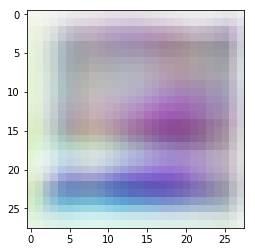

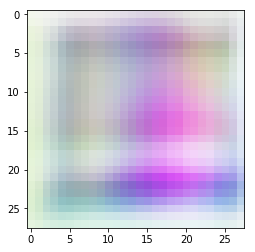

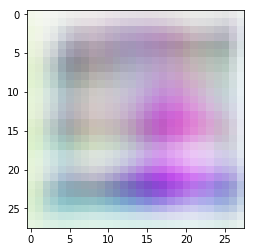

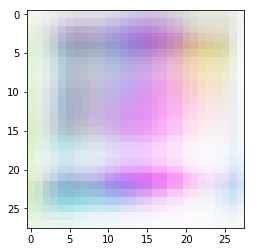

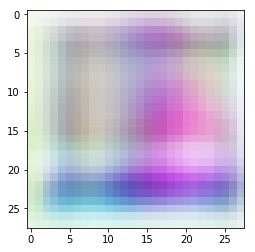

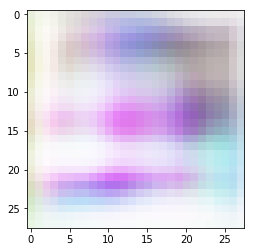

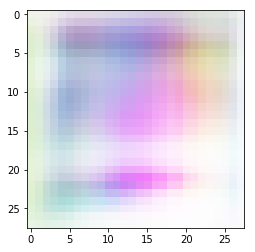

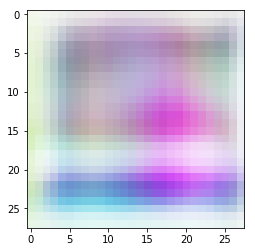

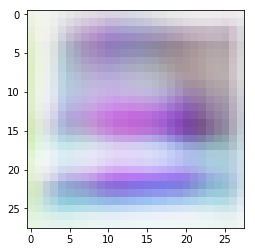

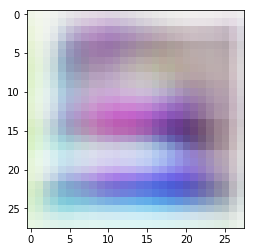

Epoch [19/50], Step [1/25], d_loss: 1.4162, g_loss: 0.5121, D(x): 0.55, D(G(z)): 0.51
Epoch [19/50], Step [2/25], d_loss: 1.4090, g_loss: 0.5108, D(x): 0.55, D(G(z)): 0.51
Epoch [19/50], Step [3/25], d_loss: 1.4227, g_loss: 0.5155, D(x): 0.54, D(G(z)): 0.51
Epoch [19/50], Step [4/25], d_loss: 1.4294, g_loss: 0.5188, D(x): 0.54, D(G(z)): 0.51
Epoch [19/50], Step [5/25], d_loss: 1.4416, g_loss: 0.5239, D(x): 0.53, D(G(z)): 0.51
Epoch [19/50], Step [6/25], d_loss: 1.4109, g_loss: 0.5368, D(x): 0.54, D(G(z)): 0.50
Epoch [19/50], Step [7/25], d_loss: 1.4100, g_loss: 0.5560, D(x): 0.54, D(G(z)): 0.50
Epoch [19/50], Step [8/25], d_loss: 1.4052, g_loss: 0.5757, D(x): 0.53, D(G(z)): 0.49
Epoch [19/50], Step [9/25], d_loss: 1.3714, g_loss: 0.6010, D(x): 0.54, D(G(z)): 0.48
Epoch [19/50], Step [10/25], d_loss: 1.3575, g_loss: 0.6237, D(x): 0.53, D(G(z)): 0.47
Epoch [19/50], Step [11/25], d_loss: 1.3504, g_loss: 0.6462, D(x): 0.53, D(G(z)): 0.46
Epoch [19/50], Step [12/25], d_loss: 1.3339, g_loss:

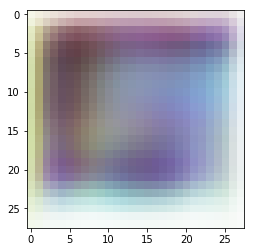

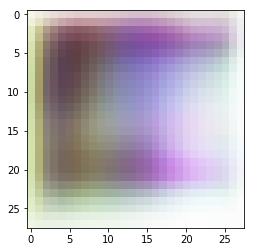

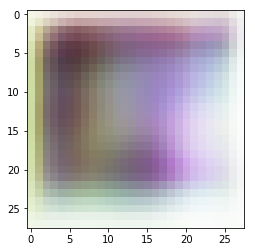

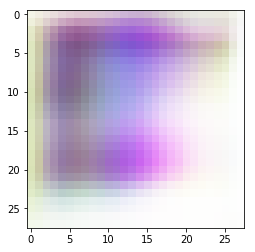

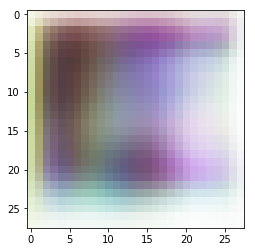

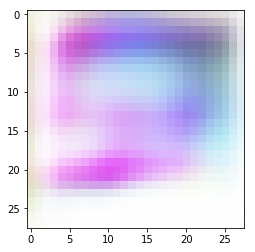

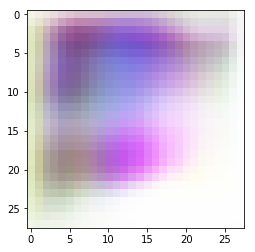

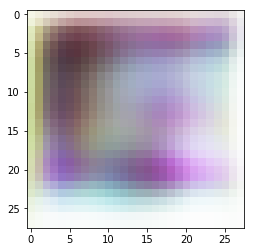

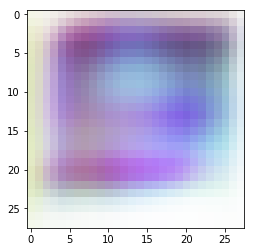

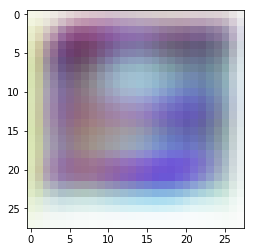

Epoch [20/50], Step [1/25], d_loss: 1.3075, g_loss: 0.6328, D(x): 0.55, D(G(z)): 0.45
Epoch [20/50], Step [2/25], d_loss: 1.3037, g_loss: 0.6177, D(x): 0.55, D(G(z)): 0.46
Epoch [20/50], Step [3/25], d_loss: 1.3196, g_loss: 0.6060, D(x): 0.55, D(G(z)): 0.47
Epoch [20/50], Step [4/25], d_loss: 1.3282, g_loss: 0.5915, D(x): 0.55, D(G(z)): 0.47
Epoch [20/50], Step [5/25], d_loss: 1.3350, g_loss: 0.5856, D(x): 0.55, D(G(z)): 0.47
Epoch [20/50], Step [6/25], d_loss: 1.3191, g_loss: 0.5749, D(x): 0.56, D(G(z)): 0.48
Epoch [20/50], Step [7/25], d_loss: 1.3323, g_loss: 0.5706, D(x): 0.55, D(G(z)): 0.48
Epoch [20/50], Step [8/25], d_loss: 1.3382, g_loss: 0.5677, D(x): 0.55, D(G(z)): 0.48
Epoch [20/50], Step [9/25], d_loss: 1.3209, g_loss: 0.5622, D(x): 0.56, D(G(z)): 0.49
Epoch [20/50], Step [10/25], d_loss: 1.3408, g_loss: 0.5605, D(x): 0.56, D(G(z)): 0.49
Epoch [20/50], Step [11/25], d_loss: 1.3409, g_loss: 0.5645, D(x): 0.55, D(G(z)): 0.49
Epoch [20/50], Step [12/25], d_loss: 1.3578, g_loss:

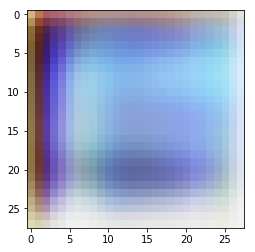

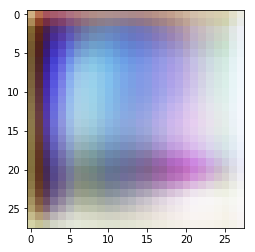

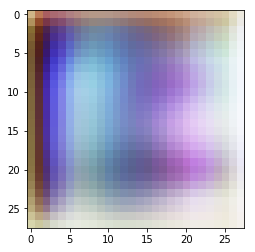

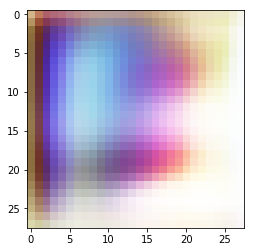

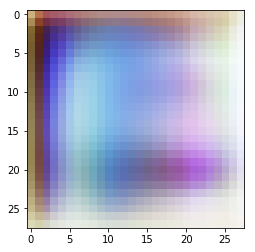

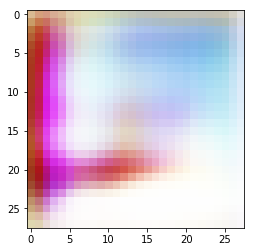

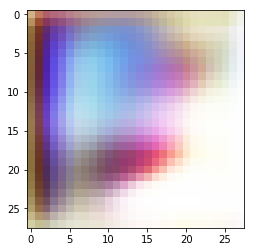

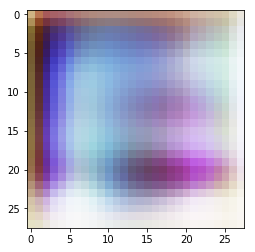

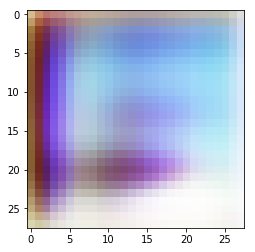

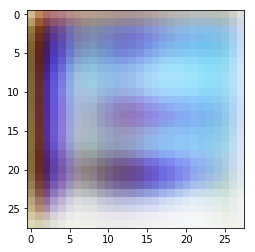

Epoch [21/50], Step [1/25], d_loss: 1.2967, g_loss: 0.6423, D(x): 0.53, D(G(z)): 0.44
Epoch [21/50], Step [2/25], d_loss: 1.2702, g_loss: 0.6331, D(x): 0.54, D(G(z)): 0.45
Epoch [21/50], Step [3/25], d_loss: 1.2654, g_loss: 0.6299, D(x): 0.54, D(G(z)): 0.44
Epoch [21/50], Step [4/25], d_loss: 1.2394, g_loss: 0.6209, D(x): 0.56, D(G(z)): 0.44
Epoch [21/50], Step [5/25], d_loss: 1.2297, g_loss: 0.6125, D(x): 0.56, D(G(z)): 0.44
Epoch [21/50], Step [6/25], d_loss: 1.2163, g_loss: 0.6025, D(x): 0.57, D(G(z)): 0.45
Epoch [21/50], Step [7/25], d_loss: 1.2059, g_loss: 0.5917, D(x): 0.58, D(G(z)): 0.45
Epoch [21/50], Step [8/25], d_loss: 1.2062, g_loss: 0.5837, D(x): 0.58, D(G(z)): 0.45
Epoch [21/50], Step [9/25], d_loss: 1.1786, g_loss: 0.5767, D(x): 0.59, D(G(z)): 0.45
Epoch [21/50], Step [10/25], d_loss: 1.1875, g_loss: 0.5701, D(x): 0.59, D(G(z)): 0.45
Epoch [21/50], Step [11/25], d_loss: 1.1826, g_loss: 0.5688, D(x): 0.59, D(G(z)): 0.45
Epoch [21/50], Step [12/25], d_loss: 1.1748, g_loss:

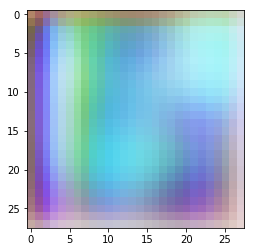

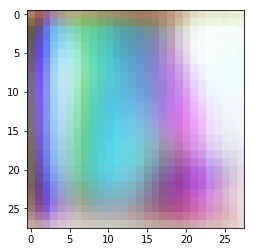

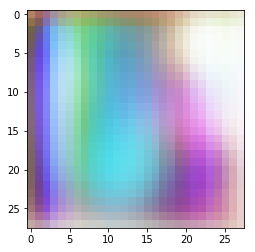

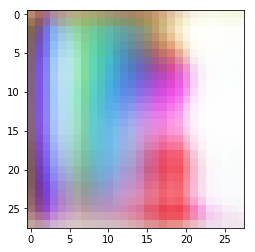

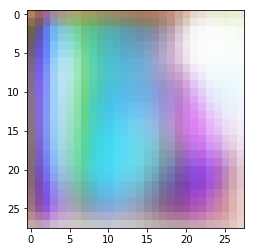

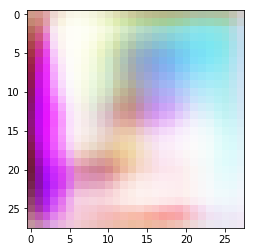

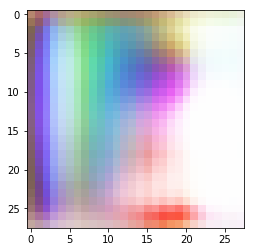

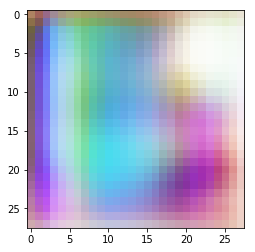

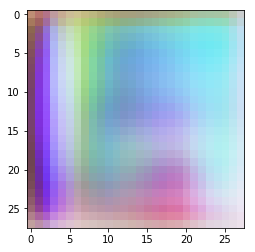

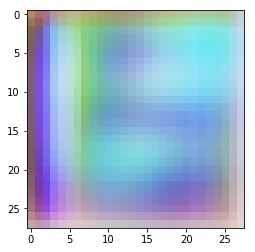

Epoch [22/50], Step [1/25], d_loss: 1.1483, g_loss: 0.5089, D(x): 0.64, D(G(z)): 0.48
Epoch [22/50], Step [2/25], d_loss: 1.1432, g_loss: 0.5050, D(x): 0.65, D(G(z)): 0.48
Epoch [22/50], Step [3/25], d_loss: 1.1521, g_loss: 0.5082, D(x): 0.65, D(G(z)): 0.48
Epoch [22/50], Step [4/25], d_loss: 1.1505, g_loss: 0.5059, D(x): 0.65, D(G(z)): 0.48
Epoch [22/50], Step [5/25], d_loss: 1.1597, g_loss: 0.5025, D(x): 0.64, D(G(z)): 0.48
Epoch [22/50], Step [6/25], d_loss: 1.1536, g_loss: 0.4976, D(x): 0.65, D(G(z)): 0.49
Epoch [22/50], Step [7/25], d_loss: 1.1567, g_loss: 0.5036, D(x): 0.65, D(G(z)): 0.49
Epoch [22/50], Step [8/25], d_loss: 1.1707, g_loss: 0.5034, D(x): 0.64, D(G(z)): 0.49
Epoch [22/50], Step [9/25], d_loss: 1.1691, g_loss: 0.5042, D(x): 0.64, D(G(z)): 0.49
Epoch [22/50], Step [10/25], d_loss: 1.1805, g_loss: 0.5083, D(x): 0.64, D(G(z)): 0.49
Epoch [22/50], Step [11/25], d_loss: 1.2017, g_loss: 0.5167, D(x): 0.63, D(G(z)): 0.49
Epoch [22/50], Step [12/25], d_loss: 1.1914, g_loss:

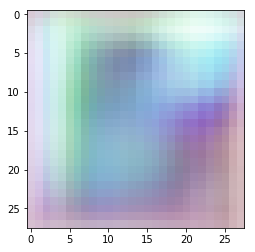

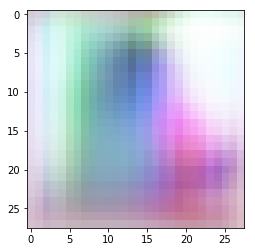

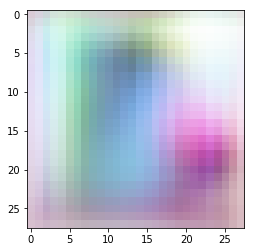

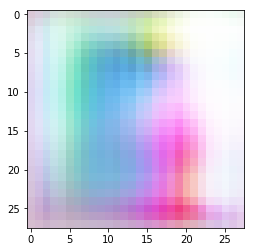

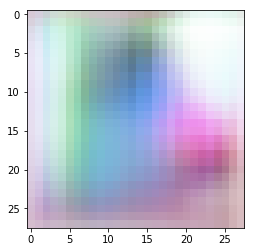

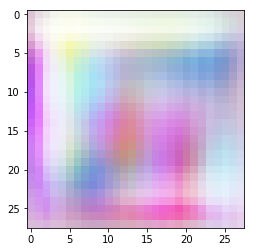

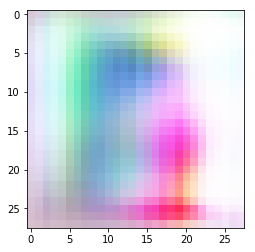

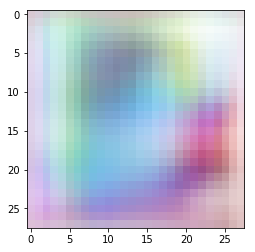

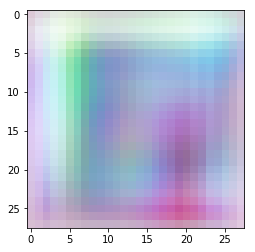

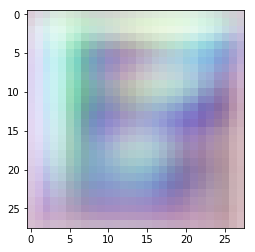

Epoch [23/50], Step [1/25], d_loss: 1.4651, g_loss: 0.3518, D(x): 0.58, D(G(z)): 0.57
Epoch [23/50], Step [2/25], d_loss: 1.4706, g_loss: 0.3527, D(x): 0.57, D(G(z)): 0.57
Epoch [23/50], Step [3/25], d_loss: 1.4884, g_loss: 0.3623, D(x): 0.56, D(G(z)): 0.57
Epoch [23/50], Step [4/25], d_loss: 1.5081, g_loss: 0.3676, D(x): 0.55, D(G(z)): 0.57
Epoch [23/50], Step [5/25], d_loss: 1.5153, g_loss: 0.3825, D(x): 0.53, D(G(z)): 0.56
Epoch [23/50], Step [6/25], d_loss: 1.5047, g_loss: 0.3976, D(x): 0.53, D(G(z)): 0.55
Epoch [23/50], Step [7/25], d_loss: 1.5039, g_loss: 0.4170, D(x): 0.52, D(G(z)): 0.54
Epoch [23/50], Step [8/25], d_loss: 1.5203, g_loss: 0.4353, D(x): 0.51, D(G(z)): 0.53
Epoch [23/50], Step [9/25], d_loss: 1.5084, g_loss: 0.4559, D(x): 0.50, D(G(z)): 0.52
Epoch [23/50], Step [10/25], d_loss: 1.5157, g_loss: 0.4742, D(x): 0.49, D(G(z)): 0.51
Epoch [23/50], Step [11/25], d_loss: 1.5161, g_loss: 0.4922, D(x): 0.48, D(G(z)): 0.50
Epoch [23/50], Step [12/25], d_loss: 1.5164, g_loss:

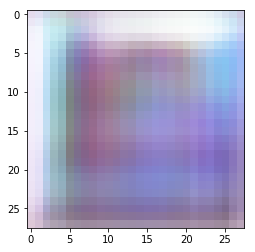

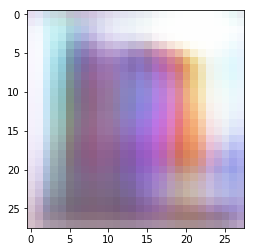

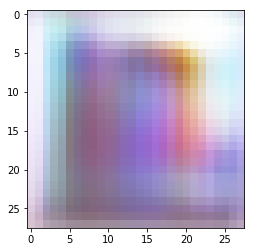

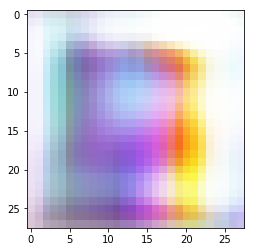

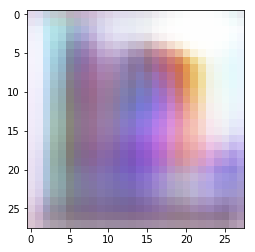

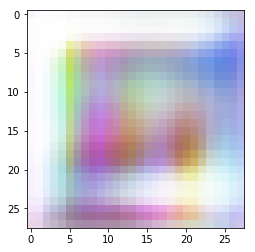

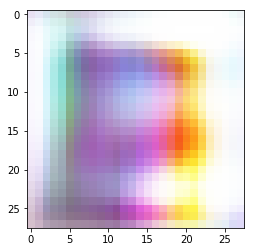

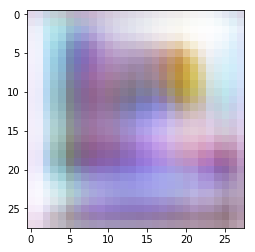

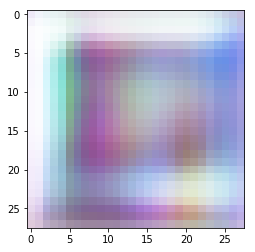

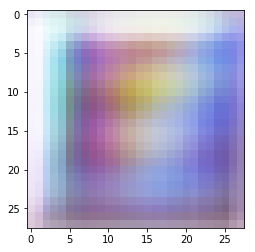

Epoch [24/50], Step [1/25], d_loss: 1.3820, g_loss: 0.5250, D(x): 0.52, D(G(z)): 0.49
Epoch [24/50], Step [2/25], d_loss: 1.3890, g_loss: 0.5266, D(x): 0.52, D(G(z)): 0.49
Epoch [24/50], Step [3/25], d_loss: 1.3847, g_loss: 0.5294, D(x): 0.52, D(G(z)): 0.49
Epoch [24/50], Step [4/25], d_loss: 1.3918, g_loss: 0.5236, D(x): 0.52, D(G(z)): 0.48
Epoch [24/50], Step [5/25], d_loss: 1.4162, g_loss: 0.5224, D(x): 0.51, D(G(z)): 0.48
Epoch [24/50], Step [6/25], d_loss: 1.4042, g_loss: 0.5170, D(x): 0.51, D(G(z)): 0.49
Epoch [24/50], Step [7/25], d_loss: 1.4226, g_loss: 0.5121, D(x): 0.51, D(G(z)): 0.49
Epoch [24/50], Step [8/25], d_loss: 1.4283, g_loss: 0.5035, D(x): 0.50, D(G(z)): 0.49
Epoch [24/50], Step [9/25], d_loss: 1.4455, g_loss: 0.4938, D(x): 0.50, D(G(z)): 0.49
Epoch [24/50], Step [10/25], d_loss: 1.4556, g_loss: 0.4820, D(x): 0.50, D(G(z)): 0.49
Epoch [24/50], Step [11/25], d_loss: 1.4672, g_loss: 0.4718, D(x): 0.50, D(G(z)): 0.50
Epoch [24/50], Step [12/25], d_loss: 1.4929, g_loss:

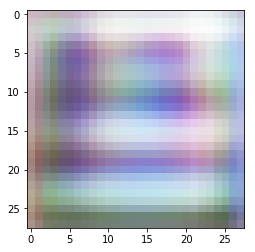

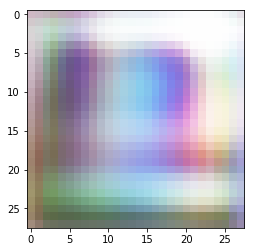

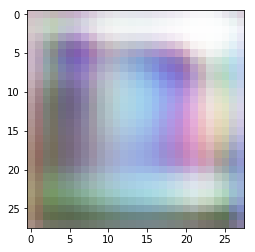

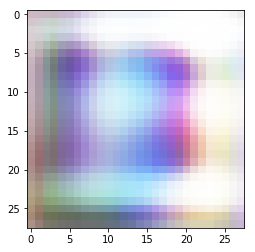

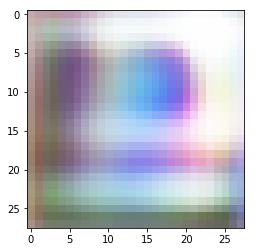

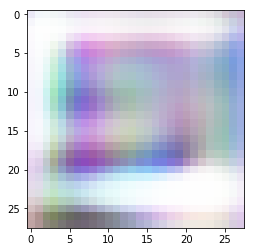

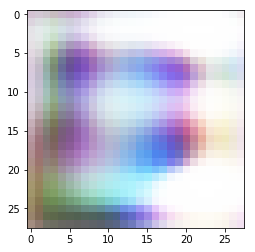

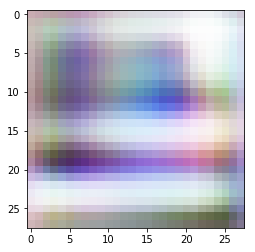

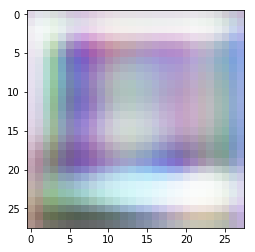

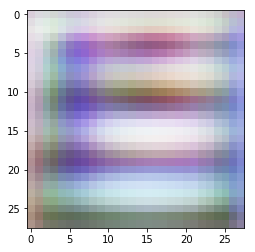

Epoch [25/50], Step [1/25], d_loss: 1.4832, g_loss: 0.4434, D(x): 0.50, D(G(z)): 0.51
Epoch [25/50], Step [2/25], d_loss: 1.4921, g_loss: 0.4490, D(x): 0.49, D(G(z)): 0.51
Epoch [25/50], Step [3/25], d_loss: 1.4795, g_loss: 0.4529, D(x): 0.49, D(G(z)): 0.51
Epoch [25/50], Step [4/25], d_loss: 1.4813, g_loss: 0.4612, D(x): 0.49, D(G(z)): 0.50
Epoch [25/50], Step [5/25], d_loss: 1.4837, g_loss: 0.4679, D(x): 0.49, D(G(z)): 0.50
Epoch [25/50], Step [6/25], d_loss: 1.4597, g_loss: 0.4785, D(x): 0.50, D(G(z)): 0.50
Epoch [25/50], Step [7/25], d_loss: 1.4666, g_loss: 0.4826, D(x): 0.49, D(G(z)): 0.50
Epoch [25/50], Step [8/25], d_loss: 1.4564, g_loss: 0.4911, D(x): 0.49, D(G(z)): 0.49
Epoch [25/50], Step [9/25], d_loss: 1.4481, g_loss: 0.5011, D(x): 0.49, D(G(z)): 0.49
Epoch [25/50], Step [10/25], d_loss: 1.4392, g_loss: 0.5045, D(x): 0.49, D(G(z)): 0.49
Epoch [25/50], Step [11/25], d_loss: 1.4350, g_loss: 0.5146, D(x): 0.49, D(G(z)): 0.49
Epoch [25/50], Step [12/25], d_loss: 1.4280, g_loss:

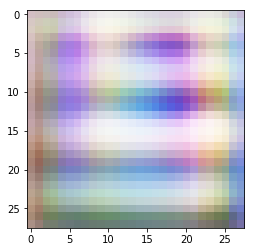

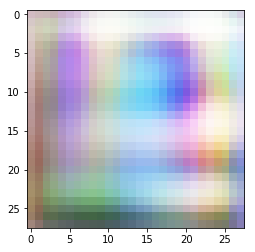

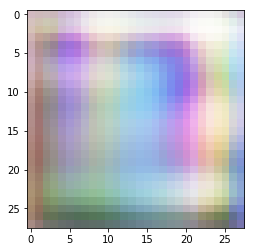

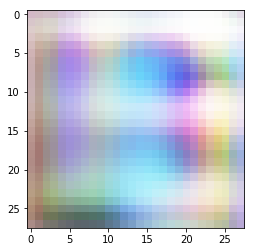

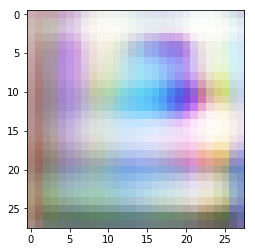

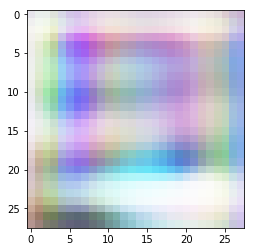

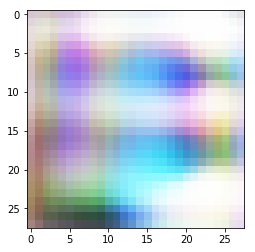

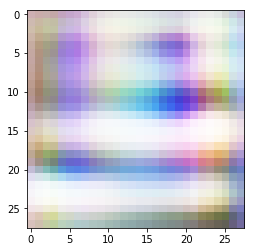

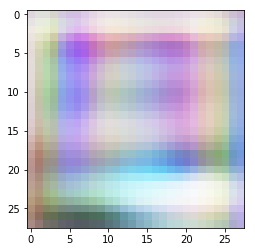

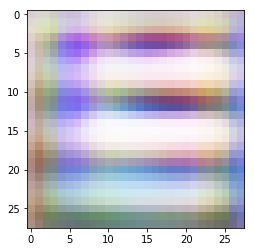

Epoch [26/50], Step [1/25], d_loss: 1.2071, g_loss: 0.5751, D(x): 0.59, D(G(z)): 0.46
Epoch [26/50], Step [2/25], d_loss: 1.2192, g_loss: 0.5765, D(x): 0.59, D(G(z)): 0.47
Epoch [26/50], Step [3/25], d_loss: 1.2142, g_loss: 0.5765, D(x): 0.59, D(G(z)): 0.47
Epoch [26/50], Step [4/25], d_loss: 1.2283, g_loss: 0.5747, D(x): 0.58, D(G(z)): 0.47
Epoch [26/50], Step [5/25], d_loss: 1.2381, g_loss: 0.5731, D(x): 0.58, D(G(z)): 0.47
Epoch [26/50], Step [6/25], d_loss: 1.2308, g_loss: 0.5729, D(x): 0.59, D(G(z)): 0.47
Epoch [26/50], Step [7/25], d_loss: 1.2443, g_loss: 0.5674, D(x): 0.58, D(G(z)): 0.47
Epoch [26/50], Step [8/25], d_loss: 1.2495, g_loss: 0.5650, D(x): 0.58, D(G(z)): 0.48
Epoch [26/50], Step [9/25], d_loss: 1.2666, g_loss: 0.5576, D(x): 0.58, D(G(z)): 0.48
Epoch [26/50], Step [10/25], d_loss: 1.2722, g_loss: 0.5528, D(x): 0.58, D(G(z)): 0.48
Epoch [26/50], Step [11/25], d_loss: 1.2898, g_loss: 0.5500, D(x): 0.57, D(G(z)): 0.49
Epoch [26/50], Step [12/25], d_loss: 1.2924, g_loss:

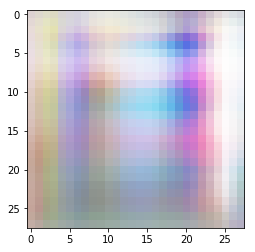

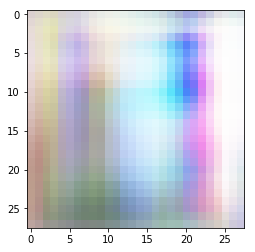

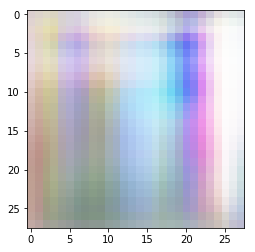

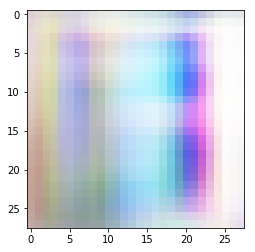

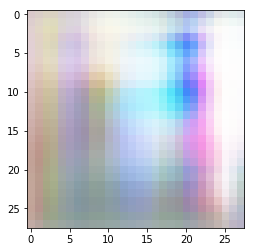

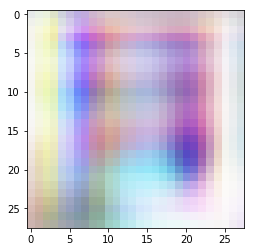

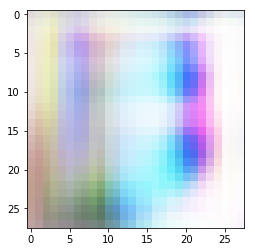

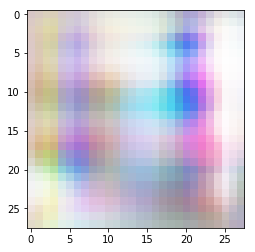

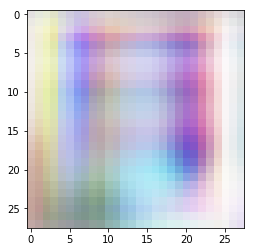

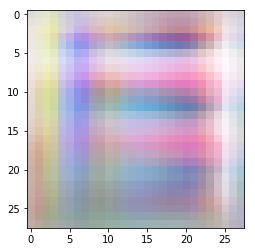

Epoch [27/50], Step [1/25], d_loss: 1.3724, g_loss: 0.5545, D(x): 0.53, D(G(z)): 0.50
Epoch [27/50], Step [2/25], d_loss: 1.3894, g_loss: 0.5591, D(x): 0.52, D(G(z)): 0.49
Epoch [27/50], Step [3/25], d_loss: 1.4055, g_loss: 0.5635, D(x): 0.51, D(G(z)): 0.49
Epoch [27/50], Step [4/25], d_loss: 1.4387, g_loss: 0.5672, D(x): 0.50, D(G(z)): 0.49
Epoch [27/50], Step [5/25], d_loss: 1.4696, g_loss: 0.5646, D(x): 0.48, D(G(z)): 0.49
Epoch [27/50], Step [6/25], d_loss: 1.4639, g_loss: 0.5634, D(x): 0.48, D(G(z)): 0.49
Epoch [27/50], Step [7/25], d_loss: 1.4802, g_loss: 0.5686, D(x): 0.47, D(G(z)): 0.49
Epoch [27/50], Step [8/25], d_loss: 1.5039, g_loss: 0.5668, D(x): 0.46, D(G(z)): 0.49
Epoch [27/50], Step [9/25], d_loss: 1.5043, g_loss: 0.5679, D(x): 0.46, D(G(z)): 0.49
Epoch [27/50], Step [10/25], d_loss: 1.5067, g_loss: 0.5717, D(x): 0.46, D(G(z)): 0.48
Epoch [27/50], Step [11/25], d_loss: 1.5219, g_loss: 0.5726, D(x): 0.45, D(G(z)): 0.48
Epoch [27/50], Step [12/25], d_loss: 1.5061, g_loss:

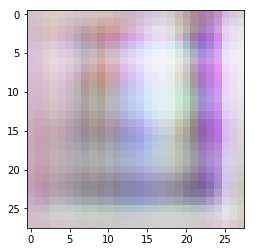

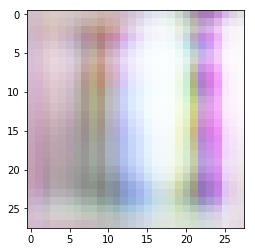

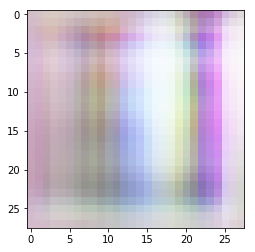

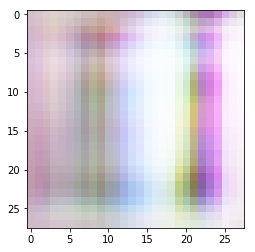

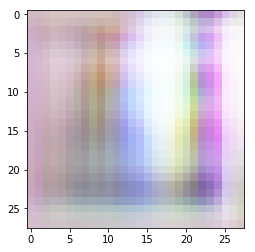

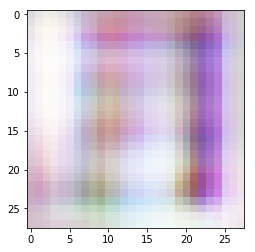

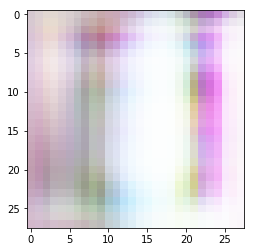

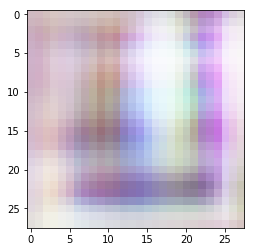

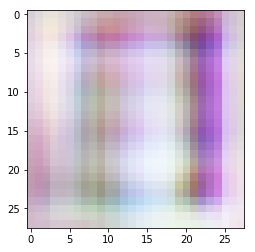

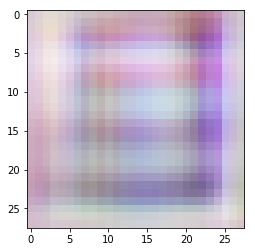

Epoch [28/50], Step [1/25], d_loss: 1.4485, g_loss: 0.5349, D(x): 0.50, D(G(z)): 0.50
Epoch [28/50], Step [2/25], d_loss: 1.4548, g_loss: 0.5333, D(x): 0.50, D(G(z)): 0.50
Epoch [28/50], Step [3/25], d_loss: 1.4417, g_loss: 0.5289, D(x): 0.51, D(G(z)): 0.51
Epoch [28/50], Step [4/25], d_loss: 1.4627, g_loss: 0.5257, D(x): 0.50, D(G(z)): 0.51
Epoch [28/50], Step [5/25], d_loss: 1.4757, g_loss: 0.5237, D(x): 0.49, D(G(z)): 0.51
Epoch [28/50], Step [6/25], d_loss: 1.4456, g_loss: 0.5251, D(x): 0.51, D(G(z)): 0.51
Epoch [28/50], Step [7/25], d_loss: 1.4467, g_loss: 0.5286, D(x): 0.51, D(G(z)): 0.51
Epoch [28/50], Step [8/25], d_loss: 1.4484, g_loss: 0.5344, D(x): 0.50, D(G(z)): 0.50
Epoch [28/50], Step [9/25], d_loss: 1.4324, g_loss: 0.5394, D(x): 0.51, D(G(z)): 0.50
Epoch [28/50], Step [10/25], d_loss: 1.4305, g_loss: 0.5446, D(x): 0.51, D(G(z)): 0.50
Epoch [28/50], Step [11/25], d_loss: 1.4337, g_loss: 0.5520, D(x): 0.50, D(G(z)): 0.50
Epoch [28/50], Step [12/25], d_loss: 1.4343, g_loss:

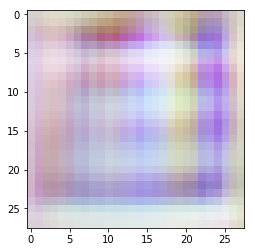

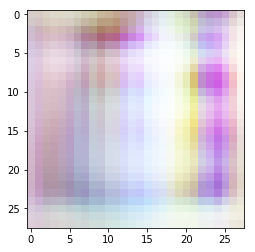

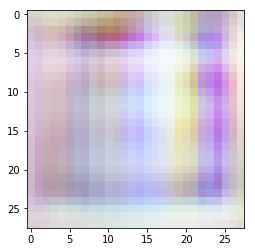

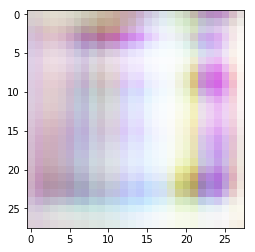

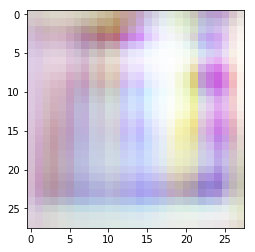

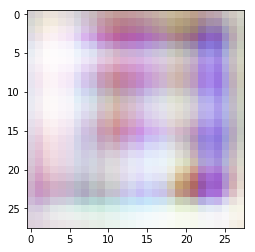

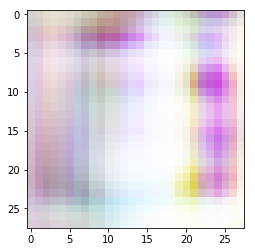

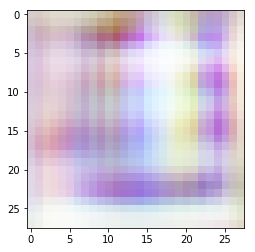

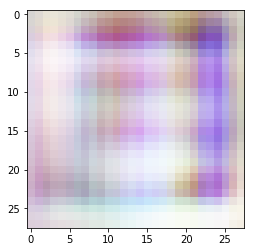

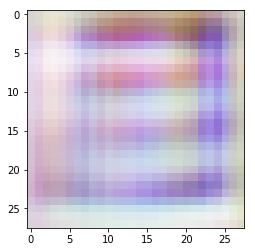

Epoch [29/50], Step [1/25], d_loss: 1.3267, g_loss: 0.6781, D(x): 0.51, D(G(z)): 0.46
Epoch [29/50], Step [2/25], d_loss: 1.3199, g_loss: 0.6994, D(x): 0.51, D(G(z)): 0.45
Epoch [29/50], Step [3/25], d_loss: 1.3153, g_loss: 0.7183, D(x): 0.51, D(G(z)): 0.44
Epoch [29/50], Step [4/25], d_loss: 1.3156, g_loss: 0.7338, D(x): 0.50, D(G(z)): 0.44
Epoch [29/50], Step [5/25], d_loss: 1.3258, g_loss: 0.7425, D(x): 0.50, D(G(z)): 0.43
Epoch [29/50], Step [6/25], d_loss: 1.3126, g_loss: 0.7484, D(x): 0.50, D(G(z)): 0.43
Epoch [29/50], Step [7/25], d_loss: 1.3129, g_loss: 0.7484, D(x): 0.50, D(G(z)): 0.43
Epoch [29/50], Step [8/25], d_loss: 1.3135, g_loss: 0.7408, D(x): 0.50, D(G(z)): 0.43
Epoch [29/50], Step [9/25], d_loss: 1.3234, g_loss: 0.7315, D(x): 0.50, D(G(z)): 0.43
Epoch [29/50], Step [10/25], d_loss: 1.3446, g_loss: 0.7120, D(x): 0.49, D(G(z)): 0.44
Epoch [29/50], Step [11/25], d_loss: 1.3597, g_loss: 0.6892, D(x): 0.49, D(G(z)): 0.44
Epoch [29/50], Step [12/25], d_loss: 1.3767, g_loss:

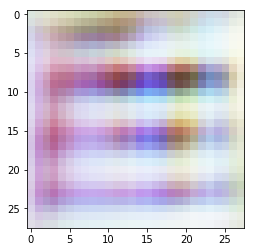

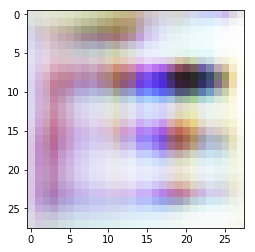

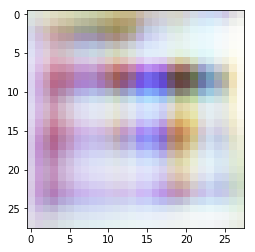

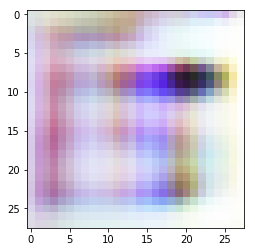

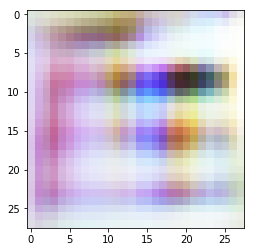

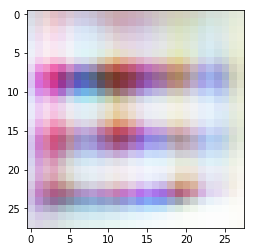

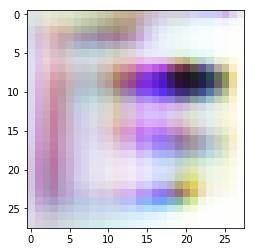

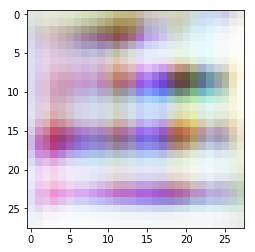

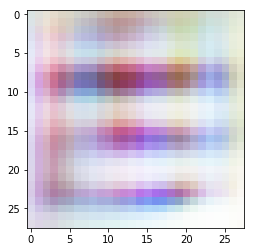

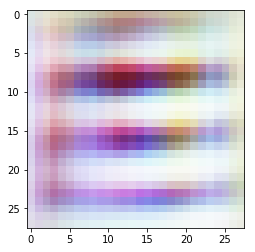

Epoch [30/50], Step [1/25], d_loss: 1.2983, g_loss: 0.6186, D(x): 0.56, D(G(z)): 0.47
Epoch [30/50], Step [2/25], d_loss: 1.2981, g_loss: 0.6287, D(x): 0.55, D(G(z)): 0.47
Epoch [30/50], Step [3/25], d_loss: 1.3049, g_loss: 0.6342, D(x): 0.55, D(G(z)): 0.47
Epoch [30/50], Step [4/25], d_loss: 1.3043, g_loss: 0.6422, D(x): 0.55, D(G(z)): 0.46
Epoch [30/50], Step [5/25], d_loss: 1.3129, g_loss: 0.6464, D(x): 0.54, D(G(z)): 0.46
Epoch [30/50], Step [6/25], d_loss: 1.2977, g_loss: 0.6552, D(x): 0.55, D(G(z)): 0.46
Epoch [30/50], Step [7/25], d_loss: 1.3021, g_loss: 0.6597, D(x): 0.54, D(G(z)): 0.46
Epoch [30/50], Step [8/25], d_loss: 1.2889, g_loss: 0.6664, D(x): 0.55, D(G(z)): 0.46
Epoch [30/50], Step [9/25], d_loss: 1.2864, g_loss: 0.6686, D(x): 0.55, D(G(z)): 0.45
Epoch [30/50], Step [10/25], d_loss: 1.2865, g_loss: 0.6739, D(x): 0.55, D(G(z)): 0.45
Epoch [30/50], Step [11/25], d_loss: 1.2835, g_loss: 0.6810, D(x): 0.54, D(G(z)): 0.45
Epoch [30/50], Step [12/25], d_loss: 1.2789, g_loss:

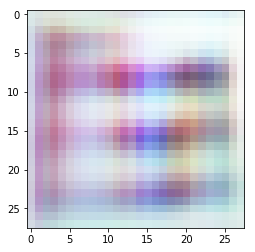

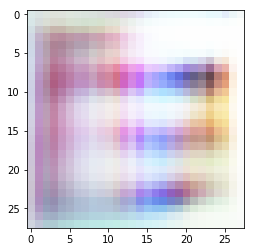

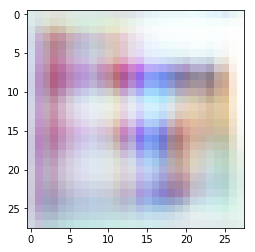

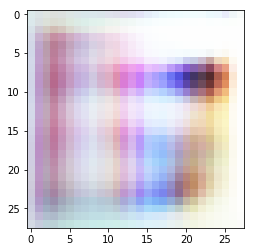

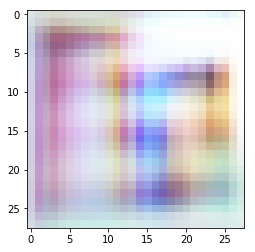

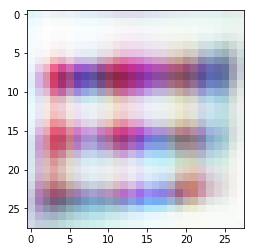

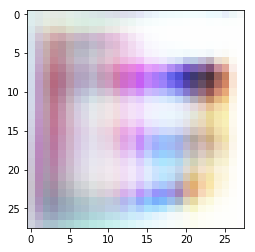

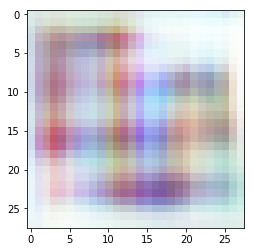

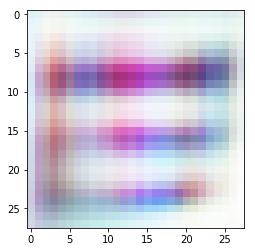

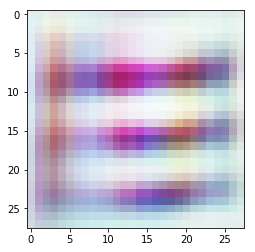

Epoch [31/50], Step [1/25], d_loss: 1.2772, g_loss: 0.5951, D(x): 0.55, D(G(z)): 0.46
Epoch [31/50], Step [2/25], d_loss: 1.2916, g_loss: 0.5827, D(x): 0.55, D(G(z)): 0.47
Epoch [31/50], Step [3/25], d_loss: 1.3124, g_loss: 0.5708, D(x): 0.55, D(G(z)): 0.47
Epoch [31/50], Step [4/25], d_loss: 1.3224, g_loss: 0.5637, D(x): 0.55, D(G(z)): 0.47
Epoch [31/50], Step [5/25], d_loss: 1.3386, g_loss: 0.5599, D(x): 0.54, D(G(z)): 0.48
Epoch [31/50], Step [6/25], d_loss: 1.3390, g_loss: 0.5579, D(x): 0.54, D(G(z)): 0.48
Epoch [31/50], Step [7/25], d_loss: 1.3356, g_loss: 0.5540, D(x): 0.54, D(G(z)): 0.48
Epoch [31/50], Step [8/25], d_loss: 1.3449, g_loss: 0.5564, D(x): 0.54, D(G(z)): 0.48
Epoch [31/50], Step [9/25], d_loss: 1.3336, g_loss: 0.5537, D(x): 0.54, D(G(z)): 0.48
Epoch [31/50], Step [10/25], d_loss: 1.3270, g_loss: 0.5544, D(x): 0.54, D(G(z)): 0.47
Epoch [31/50], Step [11/25], d_loss: 1.3260, g_loss: 0.5623, D(x): 0.54, D(G(z)): 0.47
Epoch [31/50], Step [12/25], d_loss: 1.3078, g_loss:

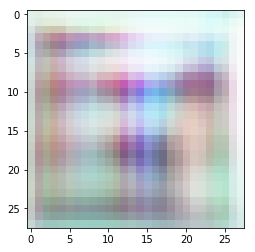

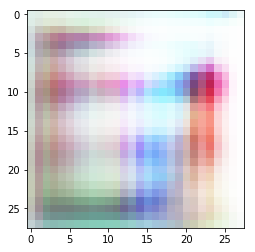

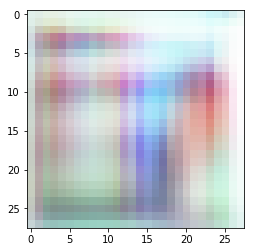

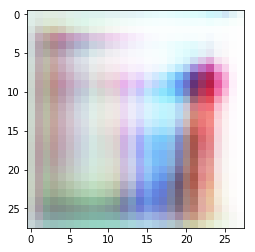

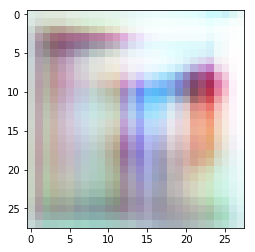

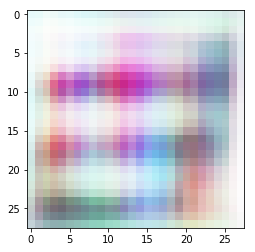

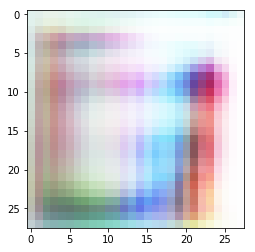

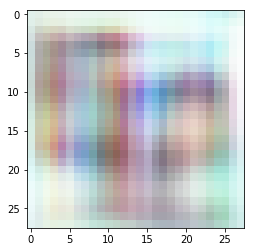

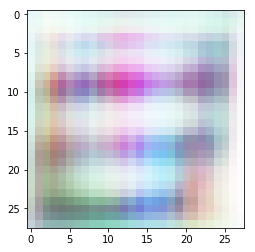

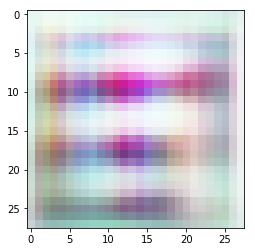

Epoch [32/50], Step [1/25], d_loss: 1.2579, g_loss: 0.5015, D(x): 0.58, D(G(z)): 0.48
Epoch [32/50], Step [2/25], d_loss: 1.2581, g_loss: 0.4884, D(x): 0.58, D(G(z)): 0.49
Epoch [32/50], Step [3/25], d_loss: 1.2767, g_loss: 0.4786, D(x): 0.58, D(G(z)): 0.49
Epoch [32/50], Step [4/25], d_loss: 1.2859, g_loss: 0.4687, D(x): 0.58, D(G(z)): 0.50
Epoch [32/50], Step [5/25], d_loss: 1.3224, g_loss: 0.4634, D(x): 0.56, D(G(z)): 0.50
Epoch [32/50], Step [6/25], d_loss: 1.3247, g_loss: 0.4536, D(x): 0.56, D(G(z)): 0.50
Epoch [32/50], Step [7/25], d_loss: 1.3330, g_loss: 0.4472, D(x): 0.57, D(G(z)): 0.51
Epoch [32/50], Step [8/25], d_loss: 1.3668, g_loss: 0.4424, D(x): 0.55, D(G(z)): 0.51
Epoch [32/50], Step [9/25], d_loss: 1.3577, g_loss: 0.4376, D(x): 0.56, D(G(z)): 0.51
Epoch [32/50], Step [10/25], d_loss: 1.3791, g_loss: 0.4337, D(x): 0.55, D(G(z)): 0.51
Epoch [32/50], Step [11/25], d_loss: 1.3967, g_loss: 0.4316, D(x): 0.55, D(G(z)): 0.52
Epoch [32/50], Step [12/25], d_loss: 1.4019, g_loss:

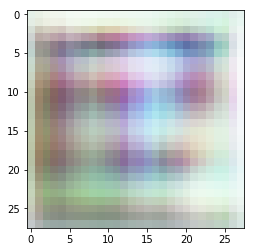

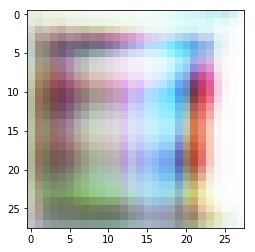

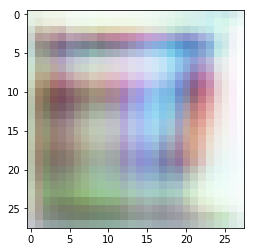

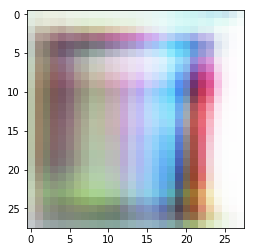

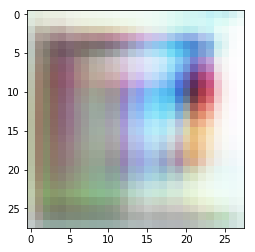

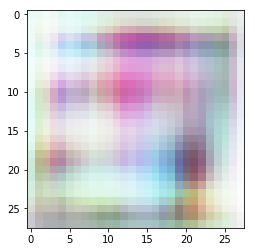

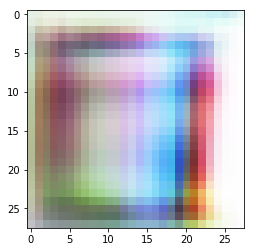

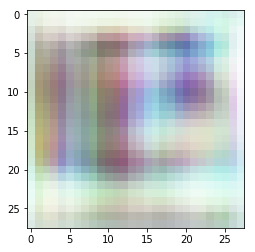

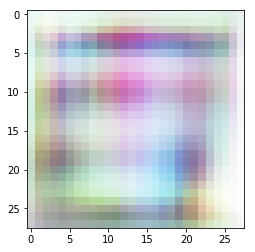

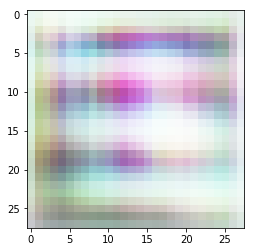

Epoch [33/50], Step [1/25], d_loss: 1.3542, g_loss: 0.5136, D(x): 0.52, D(G(z)): 0.48
Epoch [33/50], Step [2/25], d_loss: 1.3288, g_loss: 0.5239, D(x): 0.53, D(G(z)): 0.47
Epoch [33/50], Step [3/25], d_loss: 1.3188, g_loss: 0.5292, D(x): 0.53, D(G(z)): 0.47
Epoch [33/50], Step [4/25], d_loss: 1.3095, g_loss: 0.5414, D(x): 0.53, D(G(z)): 0.46
Epoch [33/50], Step [5/25], d_loss: 1.3145, g_loss: 0.5469, D(x): 0.52, D(G(z)): 0.46
Epoch [33/50], Step [6/25], d_loss: 1.3022, g_loss: 0.5510, D(x): 0.52, D(G(z)): 0.45
Epoch [33/50], Step [7/25], d_loss: 1.2849, g_loss: 0.5564, D(x): 0.53, D(G(z)): 0.45
Epoch [33/50], Step [8/25], d_loss: 1.2819, g_loss: 0.5647, D(x): 0.53, D(G(z)): 0.45
Epoch [33/50], Step [9/25], d_loss: 1.2722, g_loss: 0.5673, D(x): 0.53, D(G(z)): 0.45
Epoch [33/50], Step [10/25], d_loss: 1.2567, g_loss: 0.5652, D(x): 0.54, D(G(z)): 0.44
Epoch [33/50], Step [11/25], d_loss: 1.2533, g_loss: 0.5721, D(x): 0.54, D(G(z)): 0.44
Epoch [33/50], Step [12/25], d_loss: 1.2420, g_loss:

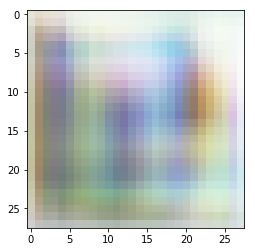

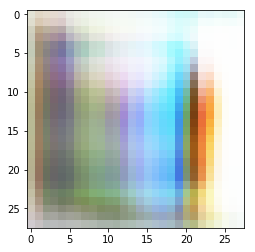

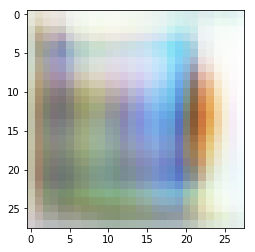

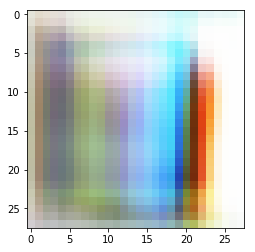

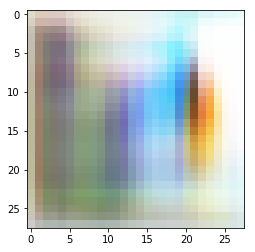

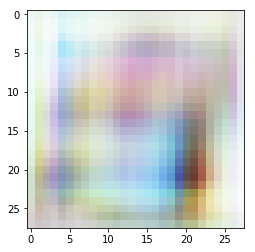

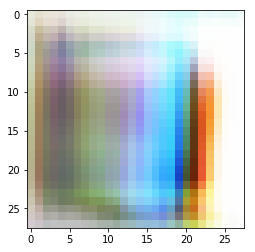

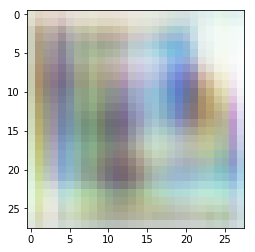

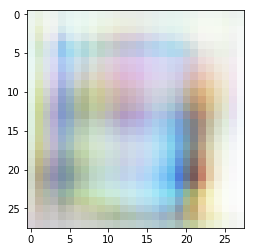

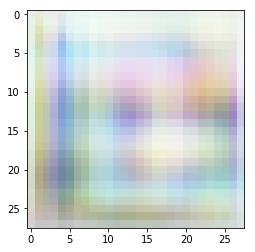

Epoch [34/50], Step [1/25], d_loss: 1.2327, g_loss: 0.4853, D(x): 0.58, D(G(z)): 0.48
Epoch [34/50], Step [2/25], d_loss: 1.2447, g_loss: 0.4800, D(x): 0.58, D(G(z)): 0.48
Epoch [34/50], Step [3/25], d_loss: 1.2495, g_loss: 0.4791, D(x): 0.58, D(G(z)): 0.48
Epoch [34/50], Step [4/25], d_loss: 1.2711, g_loss: 0.4849, D(x): 0.57, D(G(z)): 0.48
Epoch [34/50], Step [5/25], d_loss: 1.2840, g_loss: 0.4828, D(x): 0.56, D(G(z)): 0.48
Epoch [34/50], Step [6/25], d_loss: 1.2954, g_loss: 0.4908, D(x): 0.56, D(G(z)): 0.49
Epoch [34/50], Step [7/25], d_loss: 1.2969, g_loss: 0.4910, D(x): 0.55, D(G(z)): 0.48
Epoch [34/50], Step [8/25], d_loss: 1.3104, g_loss: 0.4927, D(x): 0.55, D(G(z)): 0.48
Epoch [34/50], Step [9/25], d_loss: 1.3232, g_loss: 0.4995, D(x): 0.54, D(G(z)): 0.48
Epoch [34/50], Step [10/25], d_loss: 1.3273, g_loss: 0.5031, D(x): 0.54, D(G(z)): 0.48
Epoch [34/50], Step [11/25], d_loss: 1.3306, g_loss: 0.5106, D(x): 0.53, D(G(z)): 0.48
Epoch [34/50], Step [12/25], d_loss: 1.3452, g_loss:

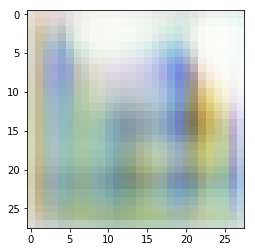

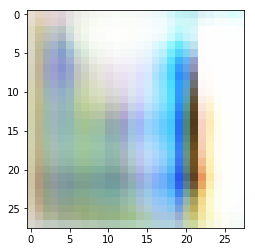

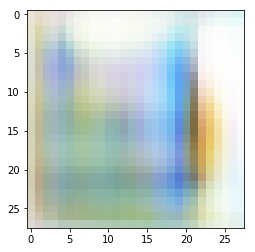

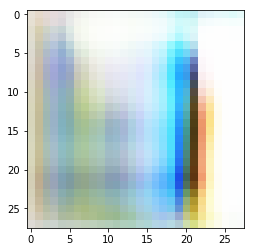

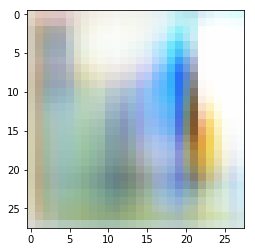

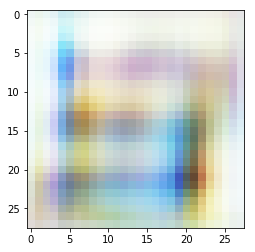

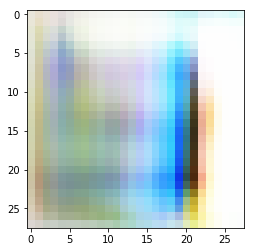

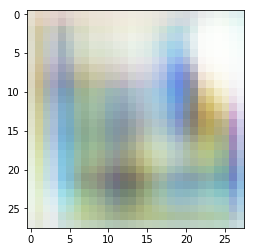

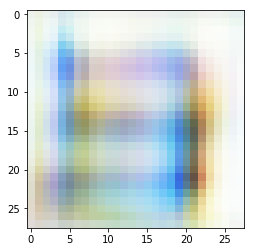

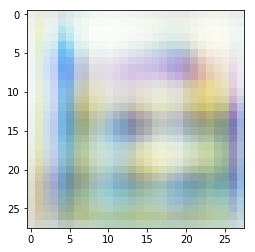

Epoch [35/50], Step [1/25], d_loss: 1.2783, g_loss: 0.5698, D(x): 0.53, D(G(z)): 0.46
Epoch [35/50], Step [2/25], d_loss: 1.2760, g_loss: 0.5694, D(x): 0.54, D(G(z)): 0.46
Epoch [35/50], Step [3/25], d_loss: 1.2656, g_loss: 0.5719, D(x): 0.54, D(G(z)): 0.46
Epoch [35/50], Step [4/25], d_loss: 1.2847, g_loss: 0.5664, D(x): 0.53, D(G(z)): 0.46
Epoch [35/50], Step [5/25], d_loss: 1.2820, g_loss: 0.5712, D(x): 0.54, D(G(z)): 0.46
Epoch [35/50], Step [6/25], d_loss: 1.2671, g_loss: 0.5660, D(x): 0.54, D(G(z)): 0.46
Epoch [35/50], Step [7/25], d_loss: 1.2627, g_loss: 0.5699, D(x): 0.54, D(G(z)): 0.46
Epoch [35/50], Step [8/25], d_loss: 1.2609, g_loss: 0.5706, D(x): 0.55, D(G(z)): 0.46
Epoch [35/50], Step [9/25], d_loss: 1.2433, g_loss: 0.5677, D(x): 0.55, D(G(z)): 0.46
Epoch [35/50], Step [10/25], d_loss: 1.2330, g_loss: 0.5721, D(x): 0.56, D(G(z)): 0.46
Epoch [35/50], Step [11/25], d_loss: 1.2247, g_loss: 0.5783, D(x): 0.56, D(G(z)): 0.45
Epoch [35/50], Step [12/25], d_loss: 1.2239, g_loss:

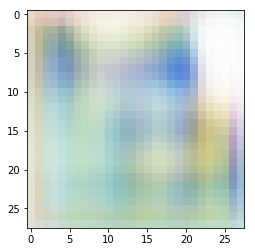

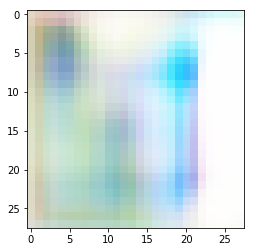

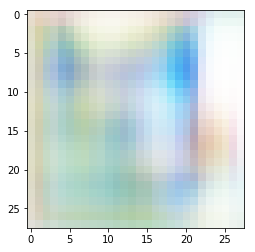

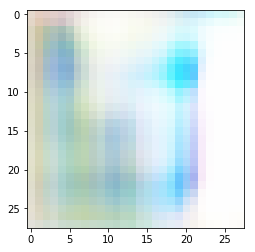

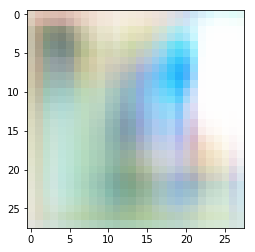

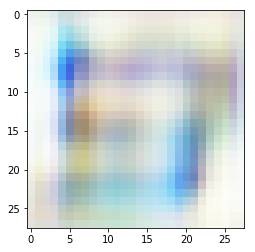

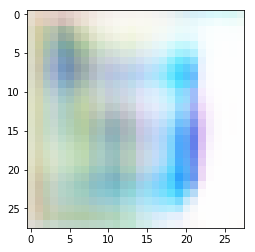

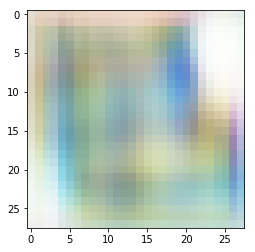

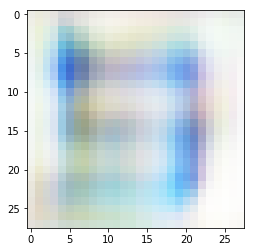

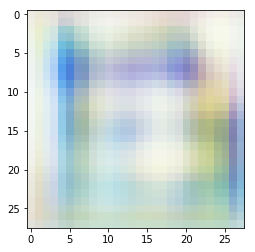

Epoch [36/50], Step [1/25], d_loss: 1.0720, g_loss: 0.6716, D(x): 0.60, D(G(z)): 0.41
Epoch [36/50], Step [2/25], d_loss: 1.0589, g_loss: 0.6725, D(x): 0.60, D(G(z)): 0.40
Epoch [36/50], Step [3/25], d_loss: 1.0555, g_loss: 0.6707, D(x): 0.60, D(G(z)): 0.40
Epoch [36/50], Step [4/25], d_loss: 1.0639, g_loss: 0.6694, D(x): 0.60, D(G(z)): 0.40
Epoch [36/50], Step [5/25], d_loss: 1.0641, g_loss: 0.6620, D(x): 0.60, D(G(z)): 0.40
Epoch [36/50], Step [6/25], d_loss: 1.0531, g_loss: 0.6555, D(x): 0.61, D(G(z)): 0.41
Epoch [36/50], Step [7/25], d_loss: 1.0627, g_loss: 0.6459, D(x): 0.61, D(G(z)): 0.41
Epoch [36/50], Step [8/25], d_loss: 1.0613, g_loss: 0.6387, D(x): 0.61, D(G(z)): 0.41
Epoch [36/50], Step [9/25], d_loss: 1.0464, g_loss: 0.6349, D(x): 0.62, D(G(z)): 0.41
Epoch [36/50], Step [10/25], d_loss: 1.0547, g_loss: 0.6242, D(x): 0.62, D(G(z)): 0.42
Epoch [36/50], Step [11/25], d_loss: 1.0537, g_loss: 0.6163, D(x): 0.62, D(G(z)): 0.42
Epoch [36/50], Step [12/25], d_loss: 1.0694, g_loss:

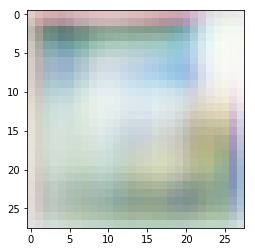

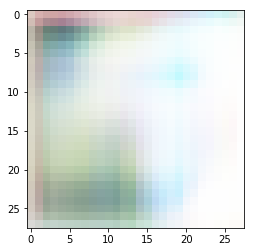

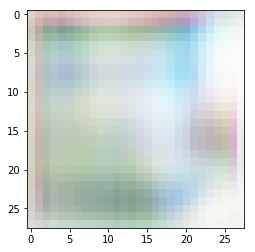

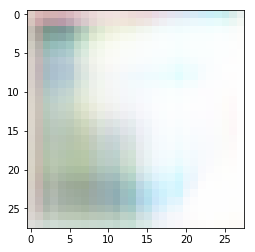

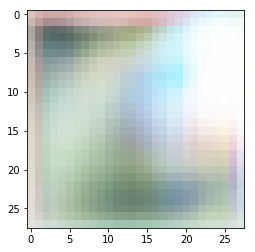

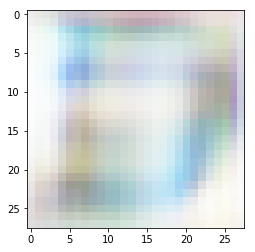

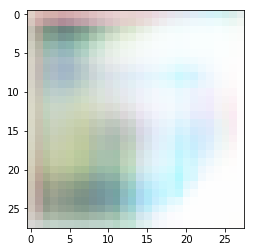

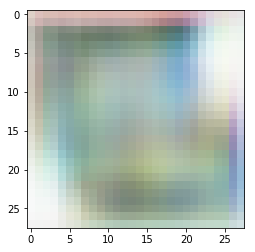

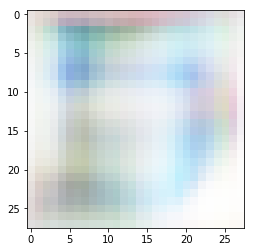

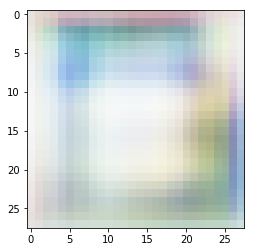

Epoch [37/50], Step [1/25], d_loss: 1.1958, g_loss: 0.5214, D(x): 0.60, D(G(z)): 0.47
Epoch [37/50], Step [2/25], d_loss: 1.2090, g_loss: 0.5218, D(x): 0.59, D(G(z)): 0.47
Epoch [37/50], Step [3/25], d_loss: 1.2120, g_loss: 0.5241, D(x): 0.59, D(G(z)): 0.47
Epoch [37/50], Step [4/25], d_loss: 1.2189, g_loss: 0.5266, D(x): 0.58, D(G(z)): 0.47
Epoch [37/50], Step [5/25], d_loss: 1.2214, g_loss: 0.5307, D(x): 0.58, D(G(z)): 0.47
Epoch [37/50], Step [6/25], d_loss: 1.2244, g_loss: 0.5364, D(x): 0.57, D(G(z)): 0.47
Epoch [37/50], Step [7/25], d_loss: 1.2394, g_loss: 0.5442, D(x): 0.56, D(G(z)): 0.46
Epoch [37/50], Step [8/25], d_loss: 1.2322, g_loss: 0.5537, D(x): 0.56, D(G(z)): 0.46
Epoch [37/50], Step [9/25], d_loss: 1.2228, g_loss: 0.5608, D(x): 0.56, D(G(z)): 0.46
Epoch [37/50], Step [10/25], d_loss: 1.2292, g_loss: 0.5705, D(x): 0.56, D(G(z)): 0.45
Epoch [37/50], Step [11/25], d_loss: 1.2113, g_loss: 0.5750, D(x): 0.56, D(G(z)): 0.45
Epoch [37/50], Step [12/25], d_loss: 1.2263, g_loss:

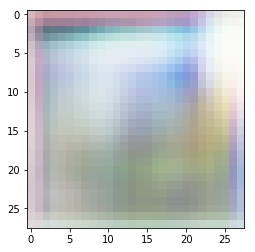

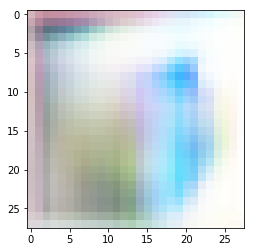

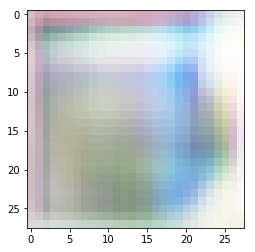

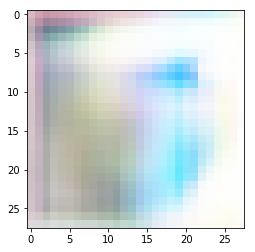

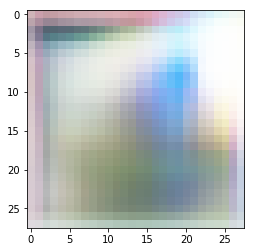

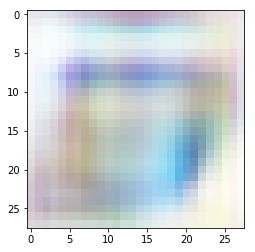

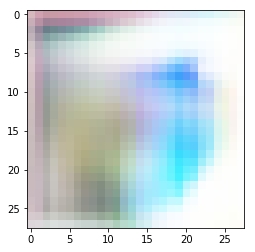

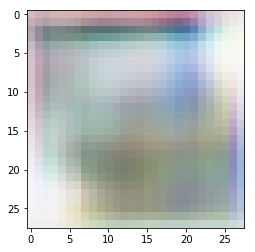

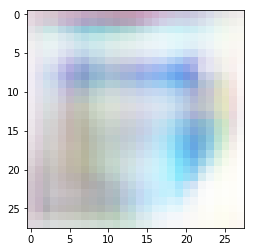

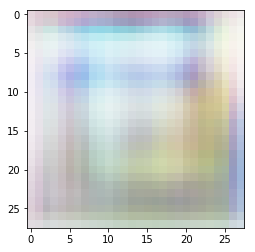

Epoch [38/50], Step [1/25], d_loss: 1.2698, g_loss: 0.5086, D(x): 0.57, D(G(z)): 0.48
Epoch [38/50], Step [2/25], d_loss: 1.2862, g_loss: 0.5160, D(x): 0.56, D(G(z)): 0.48
Epoch [38/50], Step [3/25], d_loss: 1.2829, g_loss: 0.5194, D(x): 0.56, D(G(z)): 0.48
Epoch [38/50], Step [4/25], d_loss: 1.2754, g_loss: 0.5276, D(x): 0.56, D(G(z)): 0.48
Epoch [38/50], Step [5/25], d_loss: 1.2677, g_loss: 0.5361, D(x): 0.56, D(G(z)): 0.47
Epoch [38/50], Step [6/25], d_loss: 1.2714, g_loss: 0.5430, D(x): 0.55, D(G(z)): 0.47
Epoch [38/50], Step [7/25], d_loss: 1.2786, g_loss: 0.5431, D(x): 0.55, D(G(z)): 0.47
Epoch [38/50], Step [8/25], d_loss: 1.2723, g_loss: 0.5531, D(x): 0.55, D(G(z)): 0.47
Epoch [38/50], Step [9/25], d_loss: 1.2704, g_loss: 0.5559, D(x): 0.55, D(G(z)): 0.46
Epoch [38/50], Step [10/25], d_loss: 1.2868, g_loss: 0.5529, D(x): 0.54, D(G(z)): 0.46
Epoch [38/50], Step [11/25], d_loss: 1.2829, g_loss: 0.5486, D(x): 0.55, D(G(z)): 0.47
Epoch [38/50], Step [12/25], d_loss: 1.3006, g_loss:

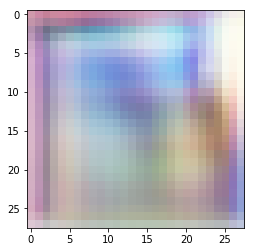

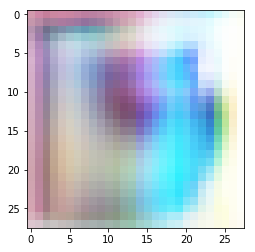

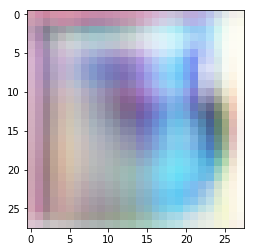

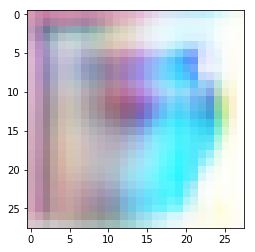

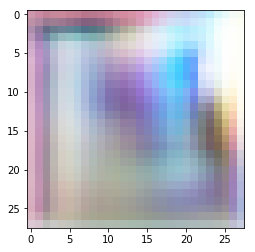

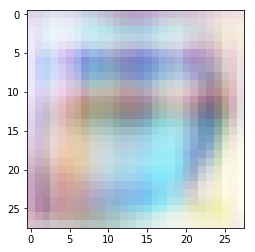

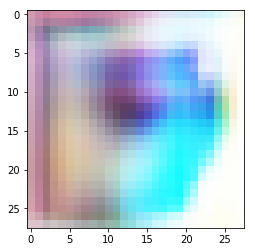

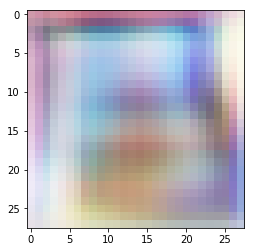

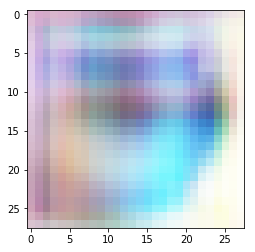

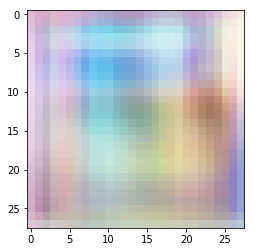

Epoch [39/50], Step [1/25], d_loss: 1.3299, g_loss: 0.4901, D(x): 0.54, D(G(z)): 0.48
Epoch [39/50], Step [2/25], d_loss: 1.3366, g_loss: 0.4914, D(x): 0.54, D(G(z)): 0.48
Epoch [39/50], Step [3/25], d_loss: 1.3324, g_loss: 0.4899, D(x): 0.54, D(G(z)): 0.48
Epoch [39/50], Step [4/25], d_loss: 1.3133, g_loss: 0.4908, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [5/25], d_loss: 1.3101, g_loss: 0.4932, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [6/25], d_loss: 1.3037, g_loss: 0.4939, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [7/25], d_loss: 1.2986, g_loss: 0.4974, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [8/25], d_loss: 1.3024, g_loss: 0.4968, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [9/25], d_loss: 1.2948, g_loss: 0.4982, D(x): 0.55, D(G(z)): 0.48
Epoch [39/50], Step [10/25], d_loss: 1.2961, g_loss: 0.5004, D(x): 0.55, D(G(z)): 0.47
Epoch [39/50], Step [11/25], d_loss: 1.2817, g_loss: 0.4990, D(x): 0.56, D(G(z)): 0.47
Epoch [39/50], Step [12/25], d_loss: 1.2795, g_loss:

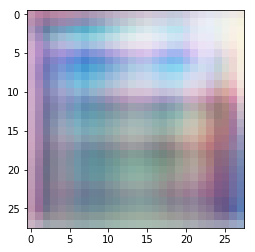

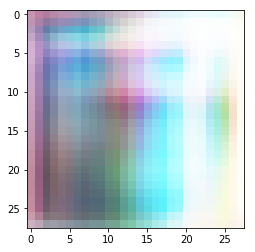

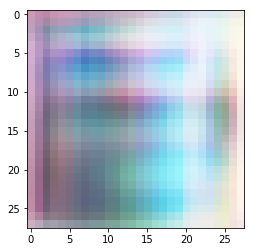

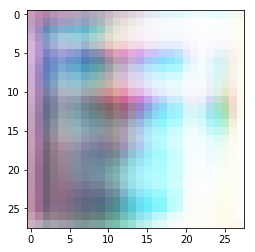

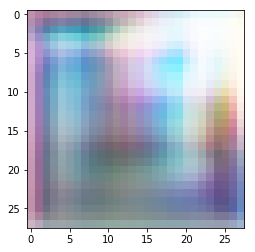

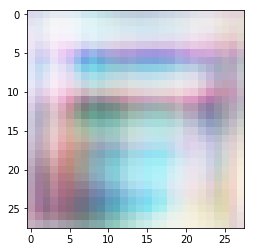

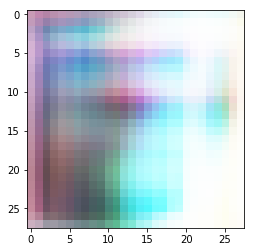

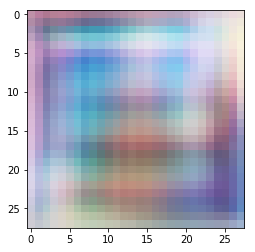

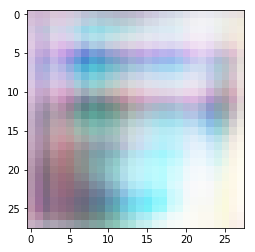

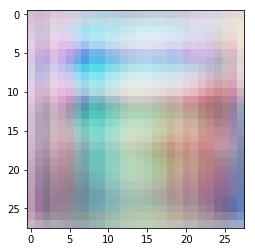

Epoch [40/50], Step [1/25], d_loss: 1.2352, g_loss: 0.4554, D(x): 0.60, D(G(z)): 0.49
Epoch [40/50], Step [2/25], d_loss: 1.2419, g_loss: 0.4479, D(x): 0.60, D(G(z)): 0.49
Epoch [40/50], Step [3/25], d_loss: 1.2466, g_loss: 0.4462, D(x): 0.60, D(G(z)): 0.50
Epoch [40/50], Step [4/25], d_loss: 1.2357, g_loss: 0.4479, D(x): 0.60, D(G(z)): 0.50
Epoch [40/50], Step [5/25], d_loss: 1.2366, g_loss: 0.4504, D(x): 0.60, D(G(z)): 0.50
Epoch [40/50], Step [6/25], d_loss: 1.2299, g_loss: 0.4587, D(x): 0.60, D(G(z)): 0.49
Epoch [40/50], Step [7/25], d_loss: 1.2195, g_loss: 0.4703, D(x): 0.60, D(G(z)): 0.49
Epoch [40/50], Step [8/25], d_loss: 1.2169, g_loss: 0.4853, D(x): 0.60, D(G(z)): 0.48
Epoch [40/50], Step [9/25], d_loss: 1.2045, g_loss: 0.5034, D(x): 0.60, D(G(z)): 0.48
Epoch [40/50], Step [10/25], d_loss: 1.1873, g_loss: 0.5204, D(x): 0.60, D(G(z)): 0.47
Epoch [40/50], Step [11/25], d_loss: 1.1795, g_loss: 0.5420, D(x): 0.60, D(G(z)): 0.46
Epoch [40/50], Step [12/25], d_loss: 1.1693, g_loss:

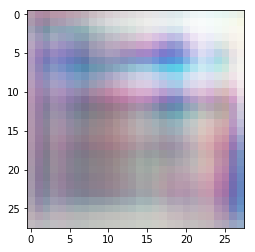

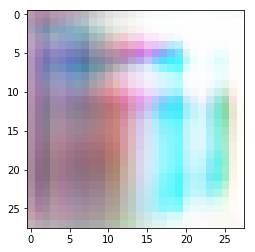

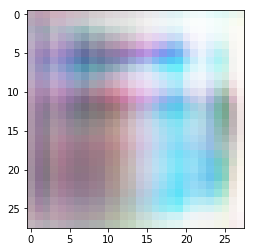

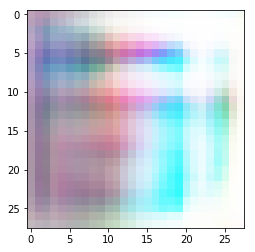

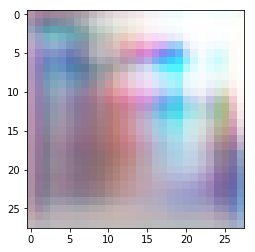

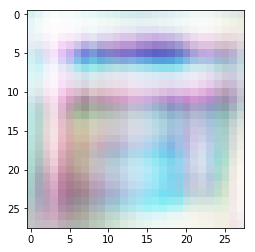

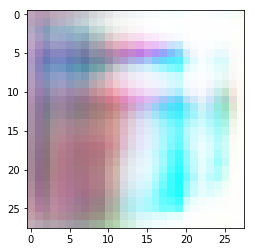

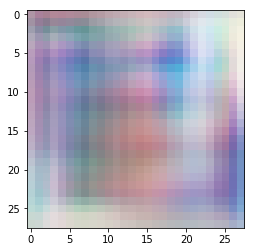

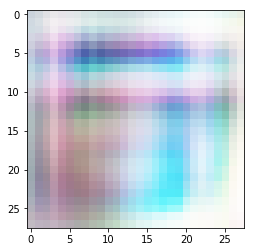

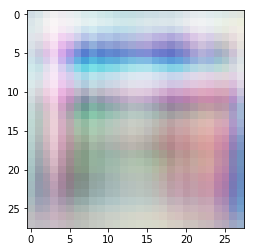

Epoch [41/50], Step [1/25], d_loss: 1.1463, g_loss: 0.5601, D(x): 0.61, D(G(z)): 0.46
Epoch [41/50], Step [2/25], d_loss: 1.1324, g_loss: 0.5683, D(x): 0.61, D(G(z)): 0.45
Epoch [41/50], Step [3/25], d_loss: 1.1288, g_loss: 0.5824, D(x): 0.61, D(G(z)): 0.45
Epoch [41/50], Step [4/25], d_loss: 1.1363, g_loss: 0.5985, D(x): 0.61, D(G(z)): 0.45
Epoch [41/50], Step [5/25], d_loss: 1.1483, g_loss: 0.6095, D(x): 0.60, D(G(z)): 0.44
Epoch [41/50], Step [6/25], d_loss: 1.1282, g_loss: 0.6259, D(x): 0.61, D(G(z)): 0.44
Epoch [41/50], Step [7/25], d_loss: 1.1216, g_loss: 0.6305, D(x): 0.61, D(G(z)): 0.44
Epoch [41/50], Step [8/25], d_loss: 1.1417, g_loss: 0.6360, D(x): 0.60, D(G(z)): 0.44
Epoch [41/50], Step [9/25], d_loss: 1.1436, g_loss: 0.6443, D(x): 0.59, D(G(z)): 0.43
Epoch [41/50], Step [10/25], d_loss: 1.1352, g_loss: 0.6380, D(x): 0.60, D(G(z)): 0.44
Epoch [41/50], Step [11/25], d_loss: 1.1543, g_loss: 0.6388, D(x): 0.59, D(G(z)): 0.44
Epoch [41/50], Step [12/25], d_loss: 1.1667, g_loss:

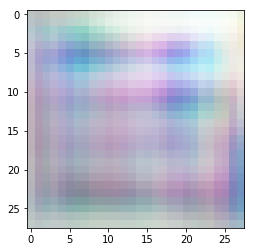

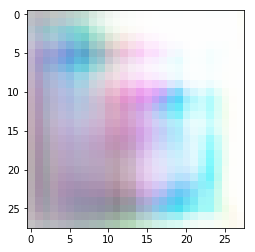

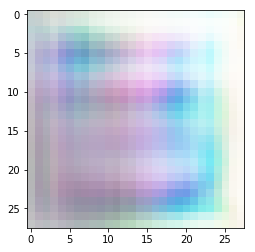

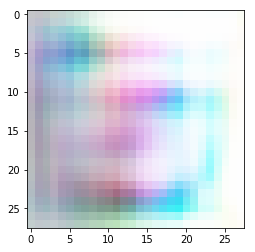

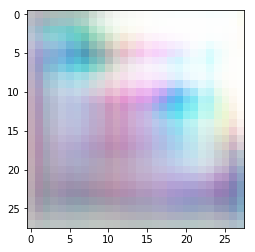

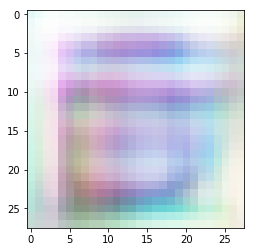

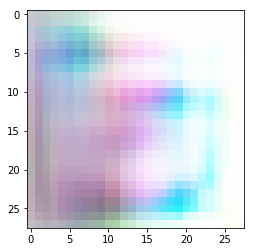

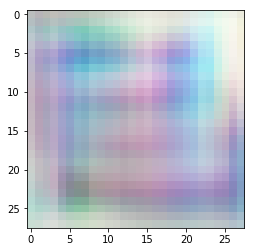

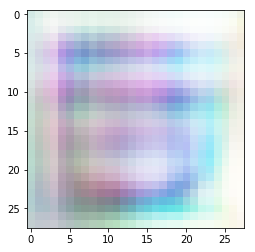

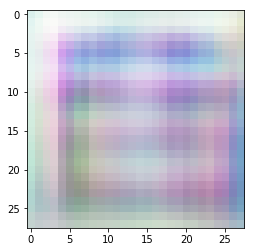

Epoch [42/50], Step [1/25], d_loss: 1.2007, g_loss: 0.6455, D(x): 0.58, D(G(z)): 0.45
Epoch [42/50], Step [2/25], d_loss: 1.2069, g_loss: 0.6485, D(x): 0.57, D(G(z)): 0.45
Epoch [42/50], Step [3/25], d_loss: 1.2091, g_loss: 0.6549, D(x): 0.57, D(G(z)): 0.45
Epoch [42/50], Step [4/25], d_loss: 1.2099, g_loss: 0.6574, D(x): 0.56, D(G(z)): 0.44
Epoch [42/50], Step [5/25], d_loss: 1.2304, g_loss: 0.6596, D(x): 0.55, D(G(z)): 0.45
Epoch [42/50], Step [6/25], d_loss: 1.2238, g_loss: 0.6626, D(x): 0.56, D(G(z)): 0.44
Epoch [42/50], Step [7/25], d_loss: 1.2395, g_loss: 0.6625, D(x): 0.55, D(G(z)): 0.44
Epoch [42/50], Step [8/25], d_loss: 1.2467, g_loss: 0.6630, D(x): 0.54, D(G(z)): 0.44
Epoch [42/50], Step [9/25], d_loss: 1.2443, g_loss: 0.6628, D(x): 0.54, D(G(z)): 0.44
Epoch [42/50], Step [10/25], d_loss: 1.2488, g_loss: 0.6666, D(x): 0.54, D(G(z)): 0.44
Epoch [42/50], Step [11/25], d_loss: 1.2493, g_loss: 0.6696, D(x): 0.54, D(G(z)): 0.44
Epoch [42/50], Step [12/25], d_loss: 1.2434, g_loss:

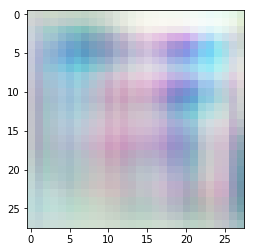

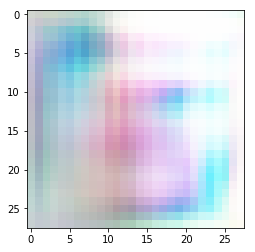

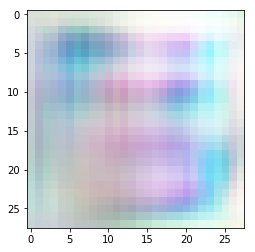

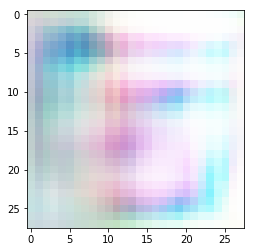

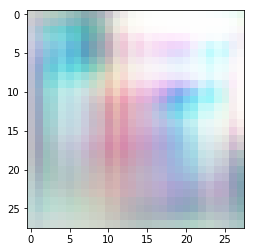

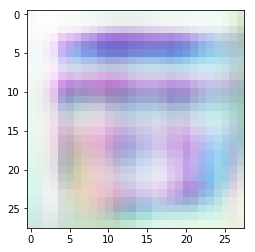

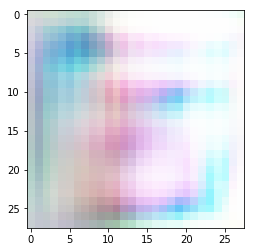

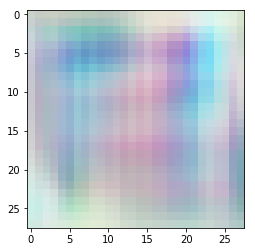

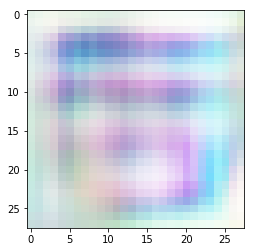

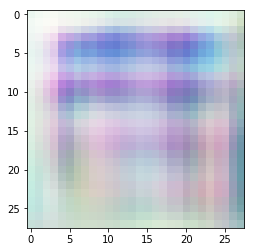

Epoch [43/50], Step [1/25], d_loss: 1.1257, g_loss: 0.7335, D(x): 0.58, D(G(z)): 0.42
Epoch [43/50], Step [2/25], d_loss: 1.1213, g_loss: 0.7386, D(x): 0.59, D(G(z)): 0.42
Epoch [43/50], Step [3/25], d_loss: 1.1298, g_loss: 0.7427, D(x): 0.58, D(G(z)): 0.42
Epoch [43/50], Step [4/25], d_loss: 1.1229, g_loss: 0.7498, D(x): 0.58, D(G(z)): 0.41
Epoch [43/50], Step [5/25], d_loss: 1.1466, g_loss: 0.7505, D(x): 0.57, D(G(z)): 0.42
Epoch [43/50], Step [6/25], d_loss: 1.1490, g_loss: 0.7502, D(x): 0.57, D(G(z)): 0.42
Epoch [43/50], Step [7/25], d_loss: 1.1638, g_loss: 0.7463, D(x): 0.56, D(G(z)): 0.42
Epoch [43/50], Step [8/25], d_loss: 1.1786, g_loss: 0.7446, D(x): 0.56, D(G(z)): 0.42
Epoch [43/50], Step [9/25], d_loss: 1.1697, g_loss: 0.7351, D(x): 0.56, D(G(z)): 0.42
Epoch [43/50], Step [10/25], d_loss: 1.2006, g_loss: 0.7270, D(x): 0.55, D(G(z)): 0.43
Epoch [43/50], Step [11/25], d_loss: 1.2067, g_loss: 0.7186, D(x): 0.55, D(G(z)): 0.43
Epoch [43/50], Step [12/25], d_loss: 1.2299, g_loss:

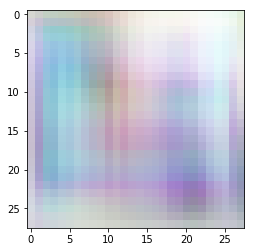

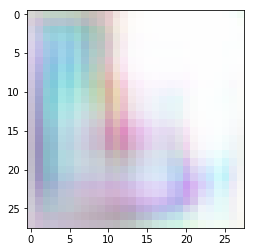

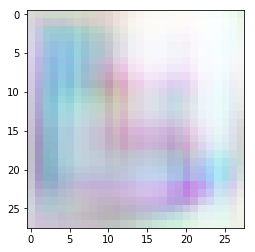

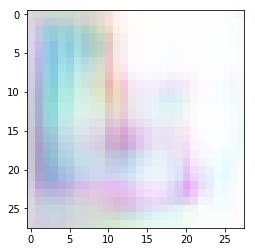

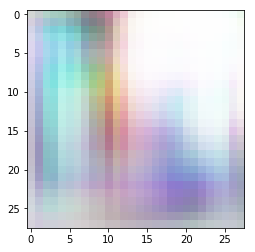

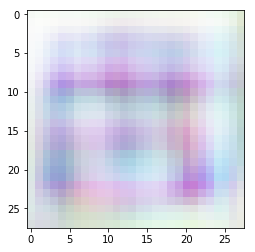

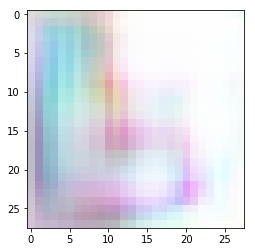

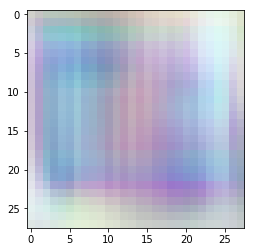

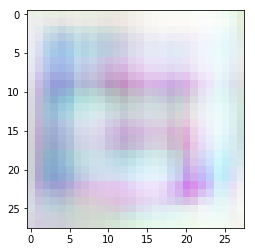

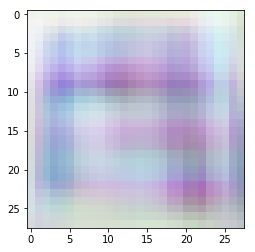

Epoch [44/50], Step [1/25], d_loss: 1.2455, g_loss: 0.6301, D(x): 0.55, D(G(z)): 0.45
Epoch [44/50], Step [2/25], d_loss: 1.2492, g_loss: 0.6229, D(x): 0.55, D(G(z)): 0.45
Epoch [44/50], Step [3/25], d_loss: 1.2583, g_loss: 0.6140, D(x): 0.55, D(G(z)): 0.46
Epoch [44/50], Step [4/25], d_loss: 1.2650, g_loss: 0.6024, D(x): 0.55, D(G(z)): 0.46
Epoch [44/50], Step [5/25], d_loss: 1.2784, g_loss: 0.6013, D(x): 0.55, D(G(z)): 0.46
Epoch [44/50], Step [6/25], d_loss: 1.2921, g_loss: 0.5982, D(x): 0.54, D(G(z)): 0.46
Epoch [44/50], Step [7/25], d_loss: 1.3086, g_loss: 0.5959, D(x): 0.53, D(G(z)): 0.46
Epoch [44/50], Step [8/25], d_loss: 1.2976, g_loss: 0.5987, D(x): 0.54, D(G(z)): 0.46
Epoch [44/50], Step [9/25], d_loss: 1.2991, g_loss: 0.6017, D(x): 0.53, D(G(z)): 0.46
Epoch [44/50], Step [10/25], d_loss: 1.3187, g_loss: 0.6064, D(x): 0.52, D(G(z)): 0.46
Epoch [44/50], Step [11/25], d_loss: 1.3153, g_loss: 0.6129, D(x): 0.52, D(G(z)): 0.46
Epoch [44/50], Step [12/25], d_loss: 1.3233, g_loss:

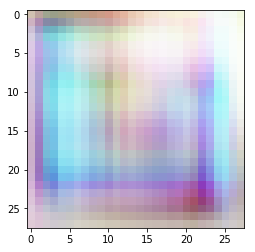

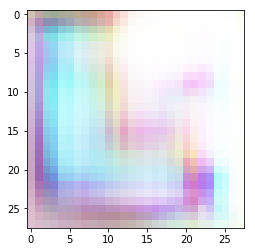

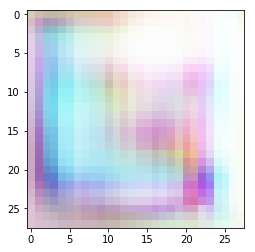

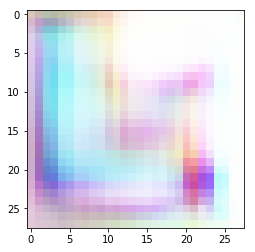

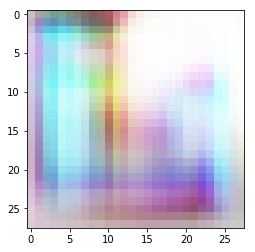

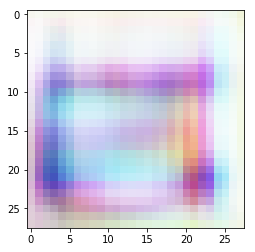

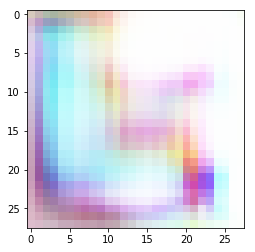

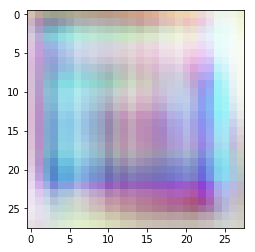

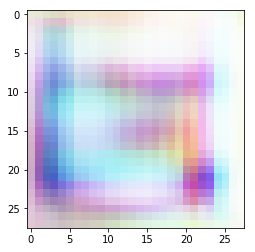

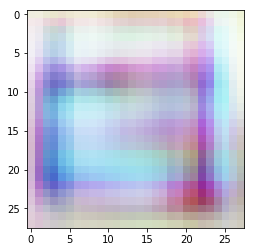

Epoch [45/50], Step [1/25], d_loss: 1.2737, g_loss: 0.5642, D(x): 0.55, D(G(z)): 0.47
Epoch [45/50], Step [2/25], d_loss: 1.2624, g_loss: 0.5665, D(x): 0.56, D(G(z)): 0.47
Epoch [45/50], Step [3/25], d_loss: 1.2737, g_loss: 0.5619, D(x): 0.56, D(G(z)): 0.47
Epoch [45/50], Step [4/25], d_loss: 1.2642, g_loss: 0.5623, D(x): 0.56, D(G(z)): 0.47
Epoch [45/50], Step [5/25], d_loss: 1.2747, g_loss: 0.5749, D(x): 0.56, D(G(z)): 0.47
Epoch [45/50], Step [6/25], d_loss: 1.2766, g_loss: 0.5770, D(x): 0.55, D(G(z)): 0.47
Epoch [45/50], Step [7/25], d_loss: 1.2864, g_loss: 0.5807, D(x): 0.55, D(G(z)): 0.47
Epoch [45/50], Step [8/25], d_loss: 1.2672, g_loss: 0.5849, D(x): 0.55, D(G(z)): 0.46
Epoch [45/50], Step [9/25], d_loss: 1.2635, g_loss: 0.5962, D(x): 0.55, D(G(z)): 0.46
Epoch [45/50], Step [10/25], d_loss: 1.2642, g_loss: 0.6067, D(x): 0.55, D(G(z)): 0.45
Epoch [45/50], Step [11/25], d_loss: 1.2539, g_loss: 0.6101, D(x): 0.55, D(G(z)): 0.45
Epoch [45/50], Step [12/25], d_loss: 1.2465, g_loss:

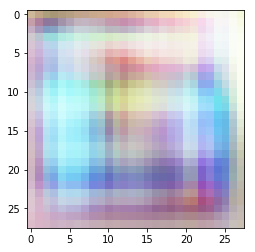

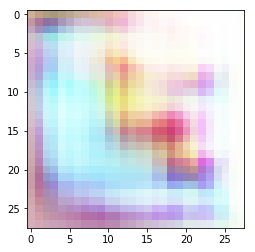

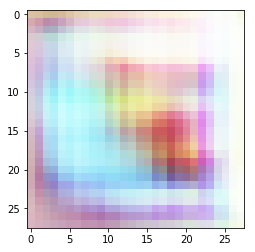

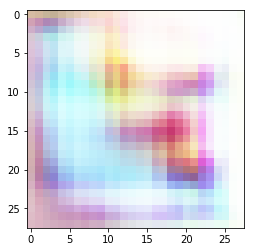

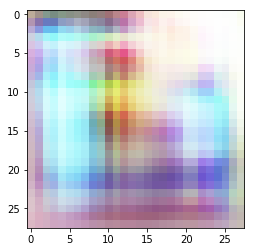

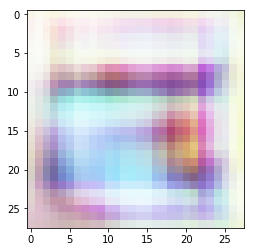

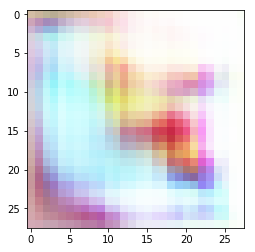

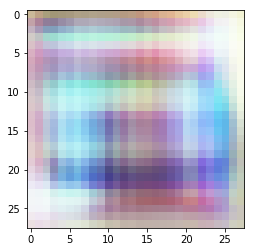

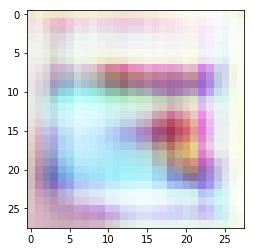

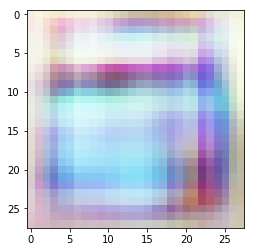

Epoch [46/50], Step [1/25], d_loss: 1.1743, g_loss: 0.5586, D(x): 0.59, D(G(z)): 0.45
Epoch [46/50], Step [2/25], d_loss: 1.1669, g_loss: 0.5603, D(x): 0.60, D(G(z)): 0.46
Epoch [46/50], Step [3/25], d_loss: 1.1635, g_loss: 0.5616, D(x): 0.60, D(G(z)): 0.45
Epoch [46/50], Step [4/25], d_loss: 1.1727, g_loss: 0.5625, D(x): 0.59, D(G(z)): 0.45
Epoch [46/50], Step [5/25], d_loss: 1.1898, g_loss: 0.5625, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [6/25], d_loss: 1.1869, g_loss: 0.5671, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [7/25], d_loss: 1.1933, g_loss: 0.5689, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [8/25], d_loss: 1.1873, g_loss: 0.5727, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [9/25], d_loss: 1.1880, g_loss: 0.5676, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [10/25], d_loss: 1.1902, g_loss: 0.5712, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [11/25], d_loss: 1.1894, g_loss: 0.5664, D(x): 0.58, D(G(z)): 0.45
Epoch [46/50], Step [12/25], d_loss: 1.1785, g_loss:

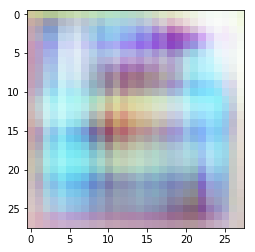

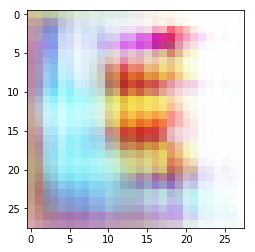

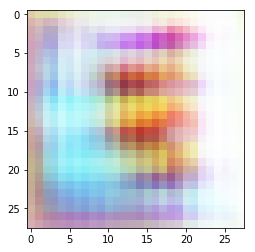

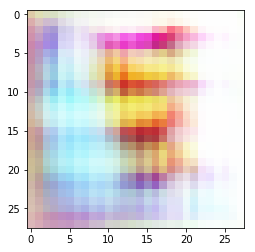

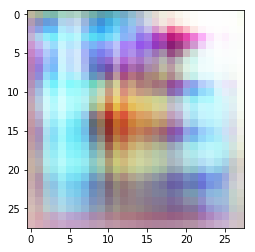

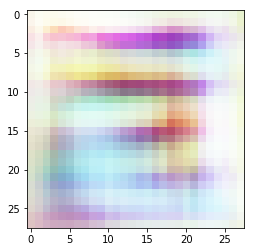

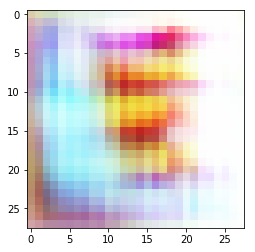

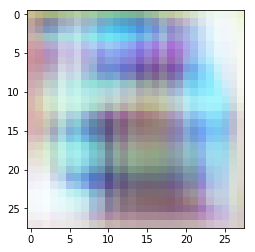

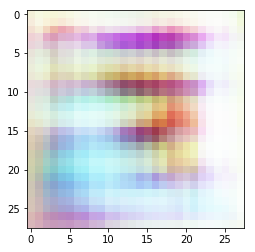

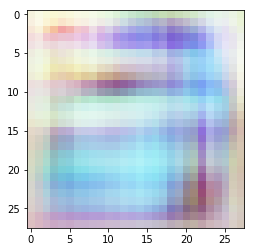

Epoch [47/50], Step [1/25], d_loss: 1.1926, g_loss: 0.4752, D(x): 0.61, D(G(z)): 0.47
Epoch [47/50], Step [2/25], d_loss: 1.1942, g_loss: 0.4638, D(x): 0.61, D(G(z)): 0.48
Epoch [47/50], Step [3/25], d_loss: 1.2002, g_loss: 0.4595, D(x): 0.61, D(G(z)): 0.48
Epoch [47/50], Step [4/25], d_loss: 1.2168, g_loss: 0.4533, D(x): 0.60, D(G(z)): 0.49
Epoch [47/50], Step [5/25], d_loss: 1.2381, g_loss: 0.4488, D(x): 0.60, D(G(z)): 0.49
Epoch [47/50], Step [6/25], d_loss: 1.2342, g_loss: 0.4456, D(x): 0.60, D(G(z)): 0.49
Epoch [47/50], Step [7/25], d_loss: 1.2456, g_loss: 0.4466, D(x): 0.59, D(G(z)): 0.49
Epoch [47/50], Step [8/25], d_loss: 1.2506, g_loss: 0.4523, D(x): 0.59, D(G(z)): 0.49
Epoch [47/50], Step [9/25], d_loss: 1.2492, g_loss: 0.4587, D(x): 0.59, D(G(z)): 0.49
Epoch [47/50], Step [10/25], d_loss: 1.2447, g_loss: 0.4658, D(x): 0.58, D(G(z)): 0.48
Epoch [47/50], Step [11/25], d_loss: 1.2467, g_loss: 0.4802, D(x): 0.58, D(G(z)): 0.48
Epoch [47/50], Step [12/25], d_loss: 1.2460, g_loss:

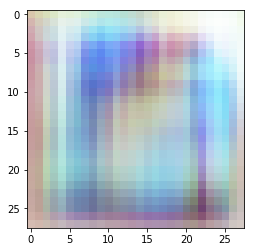

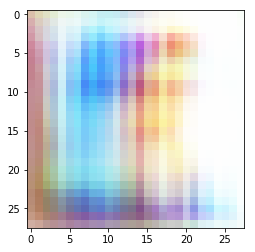

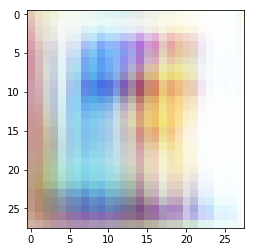

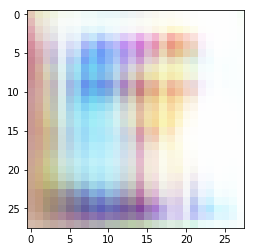

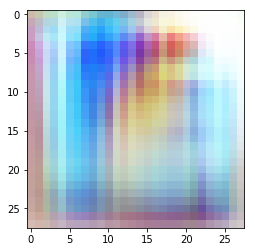

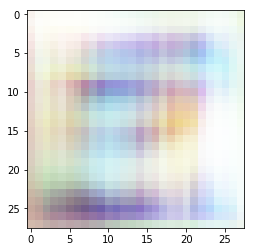

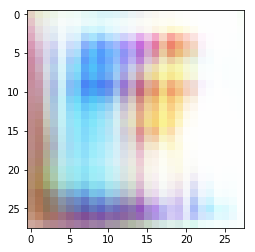

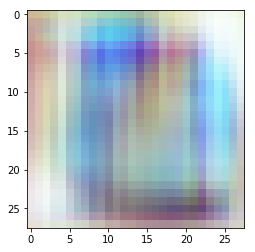

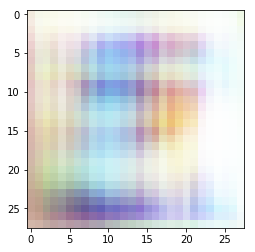

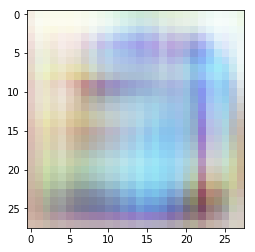

Epoch [48/50], Step [1/25], d_loss: 1.1797, g_loss: 0.5686, D(x): 0.58, D(G(z)): 0.44
Epoch [48/50], Step [2/25], d_loss: 1.1801, g_loss: 0.5587, D(x): 0.58, D(G(z)): 0.45
Epoch [48/50], Step [3/25], d_loss: 1.1824, g_loss: 0.5571, D(x): 0.58, D(G(z)): 0.45
Epoch [48/50], Step [4/25], d_loss: 1.1907, g_loss: 0.5463, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [5/25], d_loss: 1.1995, g_loss: 0.5415, D(x): 0.58, D(G(z)): 0.46
Epoch [48/50], Step [6/25], d_loss: 1.1874, g_loss: 0.5401, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [7/25], d_loss: 1.1980, g_loss: 0.5415, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [8/25], d_loss: 1.2053, g_loss: 0.5463, D(x): 0.59, D(G(z)): 0.47
Epoch [48/50], Step [9/25], d_loss: 1.1933, g_loss: 0.5432, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [10/25], d_loss: 1.1946, g_loss: 0.5499, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [11/25], d_loss: 1.1891, g_loss: 0.5574, D(x): 0.59, D(G(z)): 0.46
Epoch [48/50], Step [12/25], d_loss: 1.1973, g_loss:

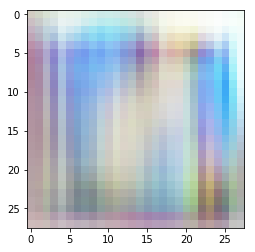

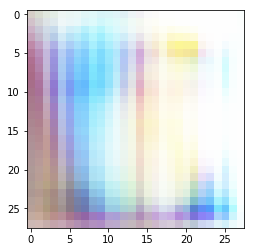

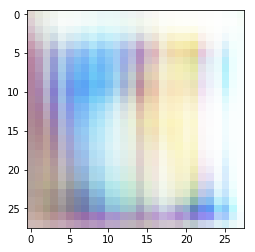

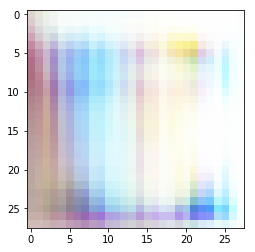

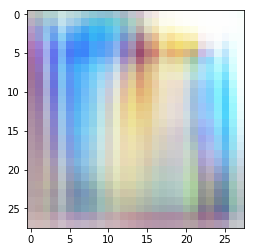

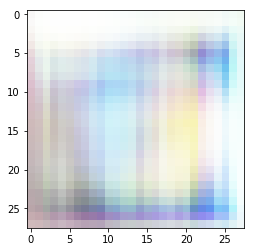

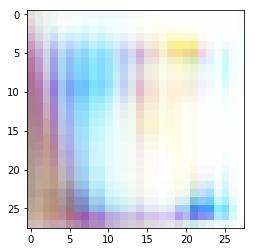

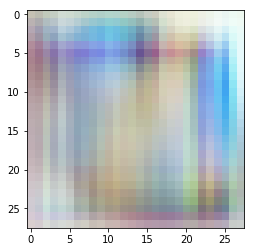

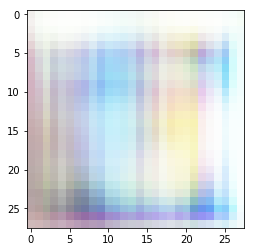

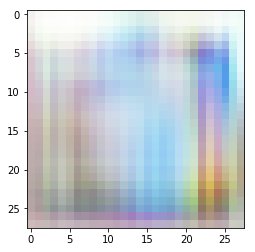

Epoch [49/50], Step [1/25], d_loss: 1.1867, g_loss: 0.6412, D(x): 0.56, D(G(z)): 0.43
Epoch [49/50], Step [2/25], d_loss: 1.1848, g_loss: 0.6399, D(x): 0.56, D(G(z)): 0.42
Epoch [49/50], Step [3/25], d_loss: 1.1950, g_loss: 0.6450, D(x): 0.56, D(G(z)): 0.42
Epoch [49/50], Step [4/25], d_loss: 1.2118, g_loss: 0.6420, D(x): 0.55, D(G(z)): 0.43
Epoch [49/50], Step [5/25], d_loss: 1.2126, g_loss: 0.6372, D(x): 0.55, D(G(z)): 0.43
Epoch [49/50], Step [6/25], d_loss: 1.1916, g_loss: 0.6274, D(x): 0.56, D(G(z)): 0.43
Epoch [49/50], Step [7/25], d_loss: 1.2079, g_loss: 0.6218, D(x): 0.56, D(G(z)): 0.44
Epoch [49/50], Step [8/25], d_loss: 1.2141, g_loss: 0.6099, D(x): 0.56, D(G(z)): 0.44
Epoch [49/50], Step [9/25], d_loss: 1.2055, g_loss: 0.6092, D(x): 0.57, D(G(z)): 0.44
Epoch [49/50], Step [10/25], d_loss: 1.2175, g_loss: 0.6012, D(x): 0.56, D(G(z)): 0.45
Epoch [49/50], Step [11/25], d_loss: 1.2121, g_loss: 0.5933, D(x): 0.57, D(G(z)): 0.45
Epoch [49/50], Step [12/25], d_loss: 1.2314, g_loss:

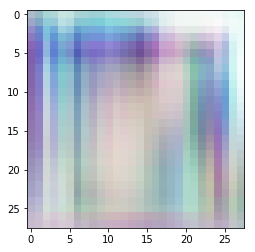

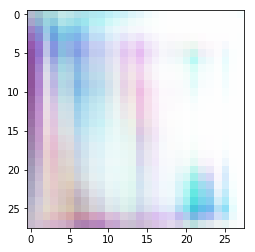

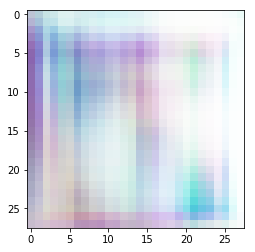

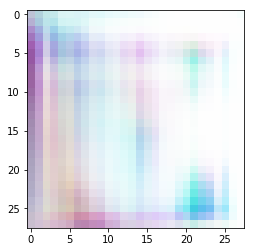

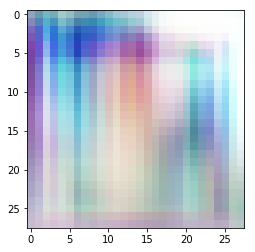

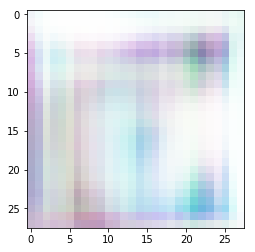

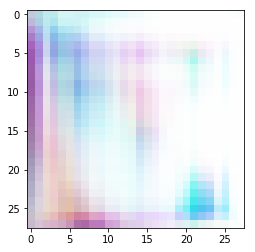

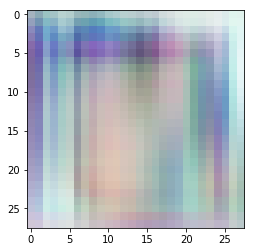

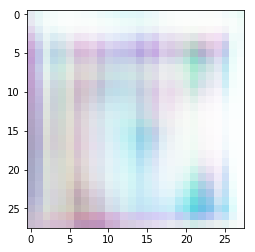

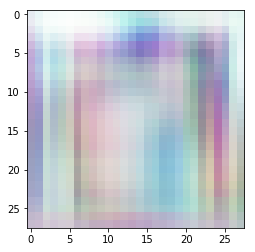

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt

num_epochs = 50

batch_size = 2000

z = torch.randn(batch_size, *latent_shape).to(device)

# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = - torch.mean(torch.log(outputs)) # criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = - torch.mean(torch.log1p(-outputs)) # criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        if d_loss > 0.5:
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
        del d_loss_real, d_loss_fake
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Compute loss with fake images
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = - torch.mean(fake_images.std(dim=0)) - torch.mean(torch.log(outputs)) # criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

    # Save real images
    if (epoch+1) == 1:
        for image in denorm(images).cpu().numpy()[:2]:
            plt.figure()
            plt.imshow(np.moveaxis(image, 0, -1))
            plt.show()
    
    # Save sampled images
    for image in denorm(fake_images).cpu().detach().numpy()[:10]:
        plt.figure()
        plt.imshow(np.moveaxis(image, 0, -1))
        plt.show()
